# California Housing Dataset

In [1]:
# Importing Standard Libraries
import pandas as pd
import numpy as np

# Importing sci-kit learn libraries
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from scipy import stats
import geopy
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = "25,10"
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.labelsize"] = 16

import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Understanding the data

In [2]:
data_raw = pd.read_csv("housing.csv")
print(data_raw.shape)
print(data_raw.info())
data_raw.head()

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### The dataset has 20640 rows and 10 columns. The number of observations are 20640. Out of the 10 columns, 1 column 'median house value' is our response and the rest of the 9 columns are predictors. Since the response is a continous, this is a regression problem. Among the 9 predictors, ocean proximity is a categorical predictor.

In [3]:
data_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [4]:
data_raw.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

#### Total bedrooms column has 207 null values. We would like to predict the missing values and fill them inplace of the Nan's. 

## Data Pre- Processing

#### Even though dropping 207 observations out of 20640 observations will not change the prediction accuracy, we would like to fill the values just as an exercise. For this purpose, we are separating the data into two dataframes- one which has the missing values and one clean dataset where we dropped the values. We can use the clean dataset for predicting a model for 'total_bedrooms'.

(207, 10)
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


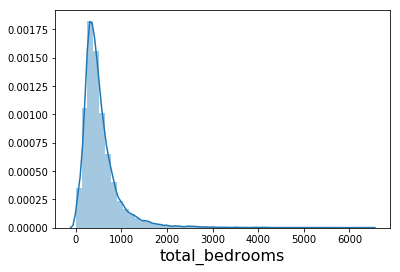

In [5]:
data_null = data_raw[data_raw.isnull().any(axis=1)]
print(data_null.shape)

data_train_br = data_raw.dropna().reset_index(drop=True)
print(data_train_br.head())

hist, ax = plt.subplots()
ax = sns.distplot(data_train_br['total_bedrooms'])

In [6]:
# Since ocean_proximity is a categorical variable, using get_dummies to create dummy variables
X = pd.get_dummies(data_train_br[['longitude', 'latitude', 'total_rooms','population',
                             'households','median_income','median_house_value','ocean_proximity']], drop_first=True)
y = data_train_br['total_bedrooms']

# splitting the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# manually creating the report for the linear regression model
model_values = np.append(model.intercept_,model.coef_)
model_names = np.append('intercept',X.columns)
model_results = pd.DataFrame(model_values, index=model_names, columns=['coef'])
print(model_results)
print(f'Model variance score is {r2_score(y_test,y_pred)}')
print(f'Model mean squared error is {mean_squared_error(y_test,y_pred)}')

                                   coef
intercept                   1786.339692
longitude                     18.735060
latitude                      14.520579
total_rooms                    0.060134
population                    -0.035492
households                     0.862545
median_income                -20.918898
median_house_value             0.000097
ocean_proximity_INLAND       -13.663458
ocean_proximity_ISLAND        76.382740
ocean_proximity_NEAR BAY       5.102816
ocean_proximity_NEAR OCEAN     3.097238
Model variance score is 0.9755704636306113
Model mean squared error is 4527.176832318375


#### The prediction accuracy score is 97%. We can use this model to predict the 'Nan' values in the total_bedrooms column of the original dataset

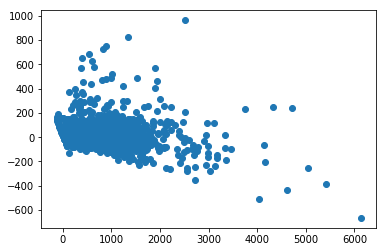

In [7]:
residuals = y_test - y_pred
plt.scatter(y_pred,residuals)

#### The residuals do not have a particular pattern, validating that we can go ahead to use the model.

In [7]:
data_null = data_null.reset_index(drop=True)
X = pd.get_dummies(data_null[['longitude', 'latitude', 'total_rooms','population',
                             'households','median_income','median_house_value','ocean_proximity']], drop_first=True)
# ocean proximity had less number of dummies in the data_null datasets and hence we are finding the missing dummy variables
feature_diff = set(X_train) - set(X)

#filling the dummy variable column with zeroes
feature_diff_df = pd.DataFrame(data=np.zeros((X.shape[0], len(feature_diff))),
                                     columns=list(feature_diff))
X = X.join(feature_diff_df)
y_pred = model.predict(X)
data_null['total_bedrooms'] = y_pred

In [8]:
#after filling the Nan values with the y_pred values, we are joining the two datasets
data_cleaned = pd.concat([data_train_br, data_null]).reset_index(drop=True)
data_cleaned.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-119.19,34.20,18.0,3620.0,783.517312,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20636,-119.18,34.19,19.0,2393.0,768.161767,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20637,-118.88,34.17,15.0,4260.0,761.098393,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20638,-118.75,34.29,17.0,5512.0,882.744730,2734.0,814.0,6.6073,258100.0,<1H OCEAN
20639,-118.72,34.28,17.0,3051.0,510.914535,1705.0,495.0,5.7376,218600.0,<1H OCEAN


In [9]:
# Scaling the data
scaler = RobustScaler()
X, y = data_cleaned.drop(['median_house_value', 'ocean_proximity'], axis=1), data_cleaned['median_house_value']
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns.tolist())

X_scaled = X_scaled.join(data_cleaned['ocean_proximity'])
data_scaled = X_scaled.join(data_cleaned['median_house_value'])

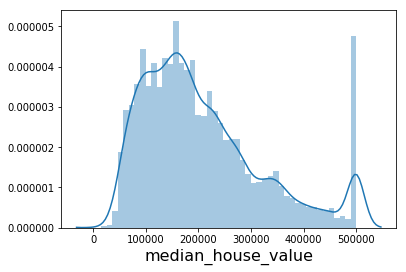

In [10]:
# Plotting the histograms
hist, ax = plt.subplots()
ax = sns.distplot(y)

#### There is a large count at 500000, which looks like an outlier. Can we proceed to remove it?

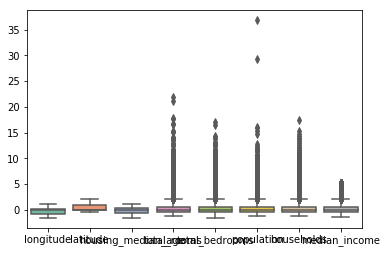

In [11]:
# Plotting the boxplots
hist, ax = plt.subplots()
ax = sns.boxplot(data=X_scaled, palette='Set2')

#### After scaling the data, plotting the data revealed outliers in several predictors. Can we remove the data which is greater than 3sigma/4 sigma?

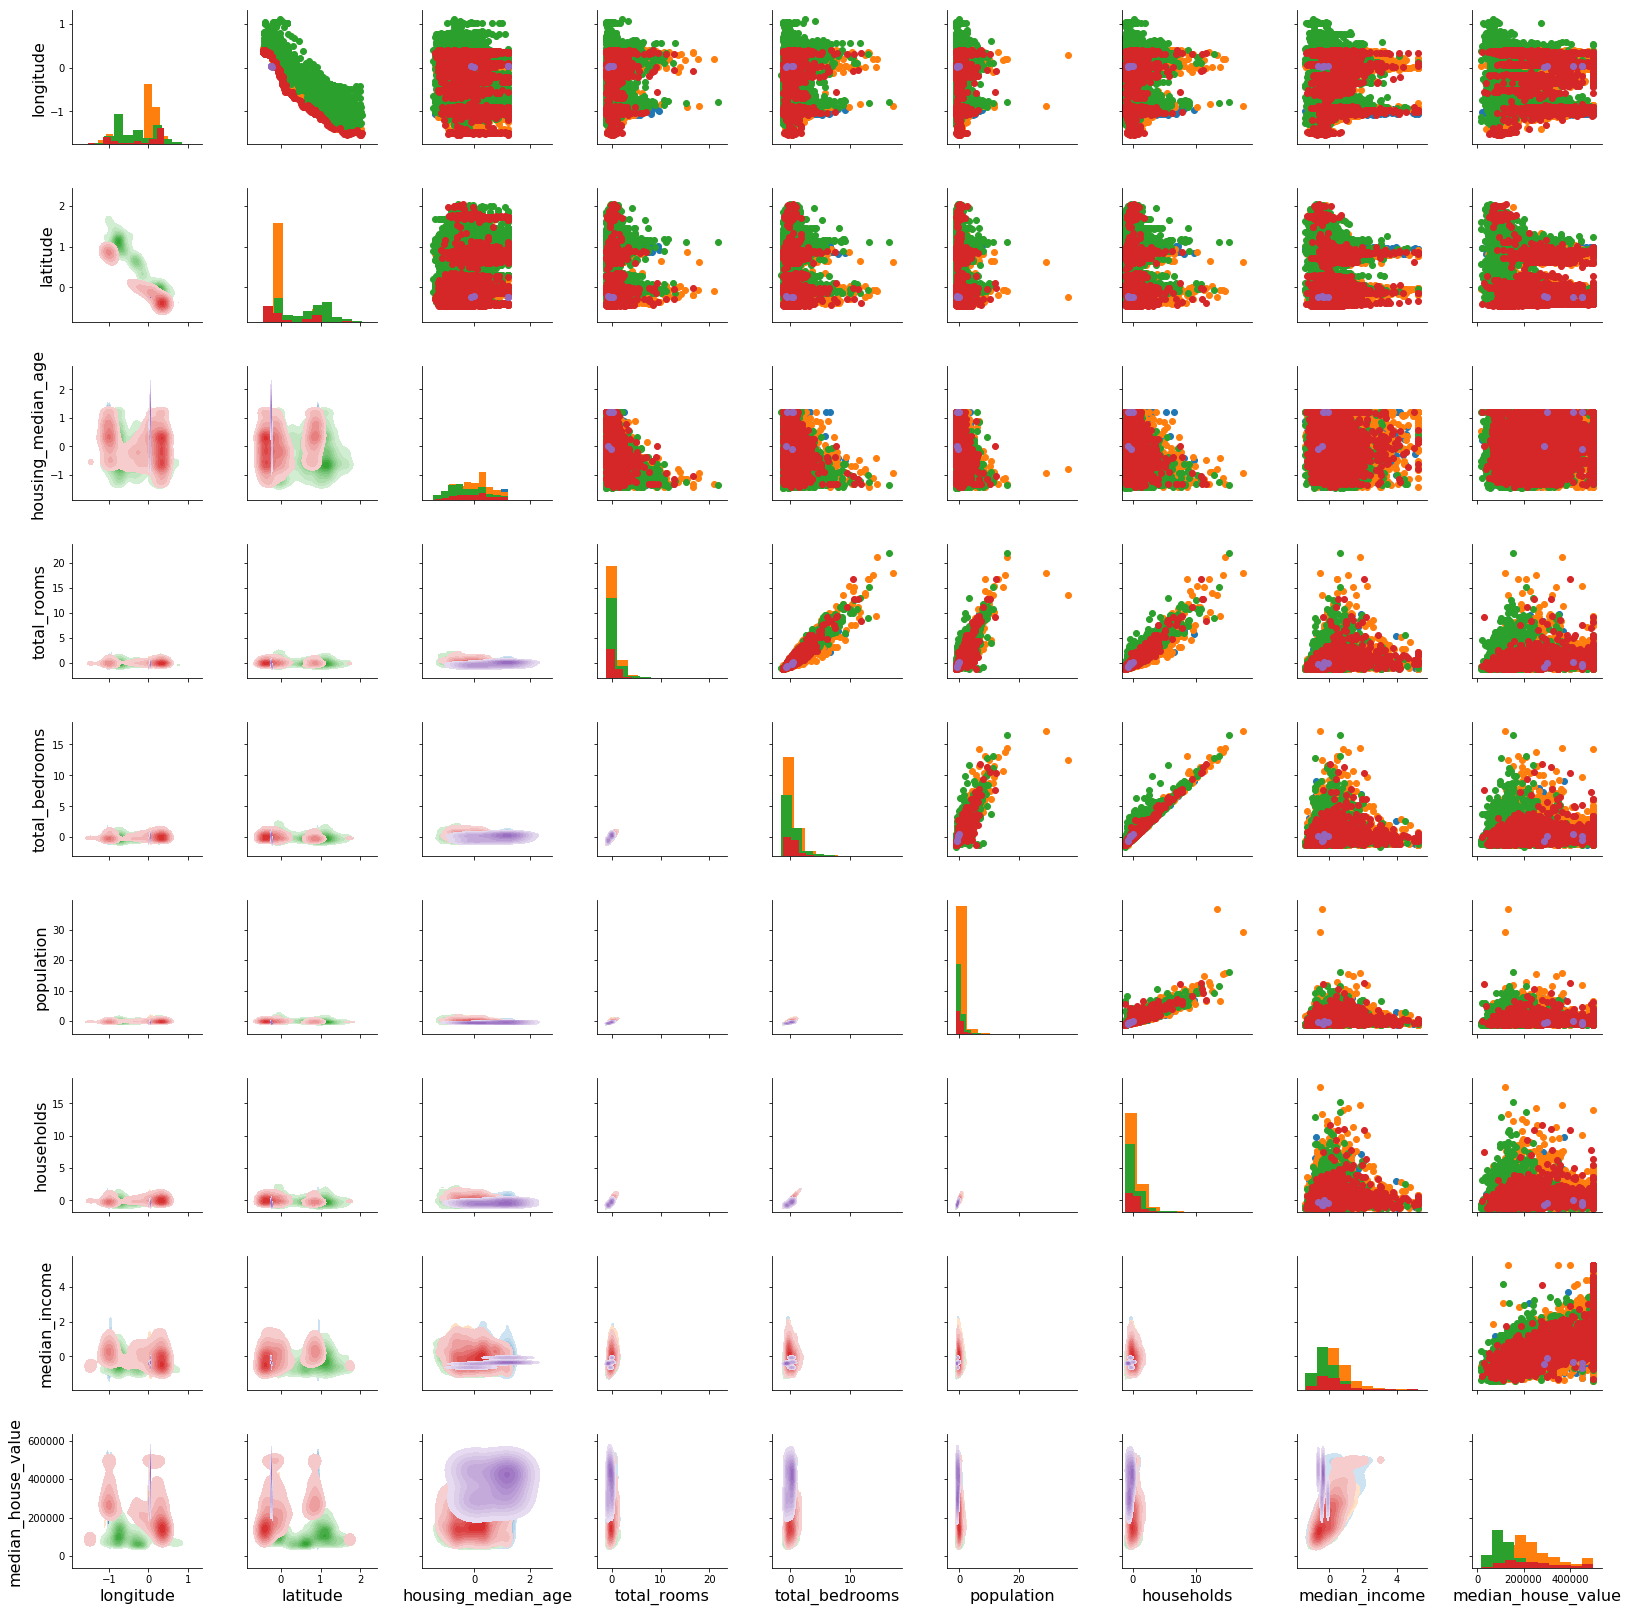

In [12]:
# Looking at the grid plots
gridplot = sns.PairGrid(data_scaled, hue='ocean_proximity')
gridplot = gridplot.map_upper(plt.scatter)
gridplot = gridplot.map_diag(plt.hist)
gridplot = gridplot.map_lower(sns.kdeplot, shade=True, shade_lowest=False)

In [13]:
print(data_scaled[data_scaled['total_rooms'] >= 3].shape)
print(data_scaled[data_scaled['total_bedrooms'] >= 3].shape)
print(data_scaled[data_scaled['median_income'] >= 3].shape)
print(data_scaled[data_scaled['population'] >= 3].shape)
print(data_scaled[data_scaled['households'] >= 3].shape)

(683, 10)
(675, 10)
(295, 10)
(592, 10)
(642, 10)


#### Removing the observations which have values greater than 3sigma removes a big portion of the data. We will first go ahead and build regression models and later on see if removing the data greater than 3/4 sigma partially or completely improves the accuracy of the model.

## Linear Regression Model

In [14]:
#creating dummies for categorical columns
X = pd.get_dummies(X_scaled, drop_first= True)

#splitting the data into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Fit model and predict
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Look at the results
values = np.append(model.intercept_, model.coef_)
names = np.append('Intercept', X.columns)
results = pd.DataFrame(values, index=names, columns=['Coef'])
print(results)
print(f'Variance score of the model is {r2_score(y_test, y_pred)}')
print(f'Mean squared error of the model is {mean_squared_error(y_test, y_pred)}')

                                     Coef
Intercept                   210852.381651
longitude                   -98021.148247
latitude                    -93614.087966
housing_median_age           20794.946145
total_rooms                 -11131.273679
total_bedrooms               35943.902918
population                  -33879.717988
households                   14419.139624
median_income                85967.030572
ocean_proximity_INLAND      -39592.419693
ocean_proximity_ISLAND      183077.830938
ocean_proximity_NEAR BAY     -5233.363568
ocean_proximity_NEAR OCEAN    5606.916872
Variance score of the model is 0.6572086916450433
Mean squared error of the model is 4565997282.2644615


#### The variance score of the model is 65.7%. 

## Random Forests

In [15]:
#Using Random forest regressor
rforest = RandomForestRegressor(random_state=42)

#Performing a randomized search for finding best parameters
param_dist = {'n_estimators': range(500,1500,500),
              'max_depth': range(1,4,1),
              'max_features': range(1,4,1),
              'min_samples_split': range(500,2000,500)
             }
rforest_cv = RandomizedSearchCV(rforest, param_distributions=param_dist, cv=10, scoring='explained_variance')

In [16]:
#X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop(['median_house_value'], axis=1), 
                                                    #data_scaled['median_house_value'], random_state=42)

rforest_cv.fit(X_train, y_train)
rforest_cv

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': range(500, 1500, 500), 'max_depth': range(1, 4), 'max_features': range(1, 4), 'min_samples_split': range(500, 2000, 500)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='explained_variance',
          verbose=0)

In [17]:
y_pred = rforest_cv.predict(X_test)
print(rforest_cv.score(X_test, y_test))
rforest_cv.best_estimator_

0.4108704249549391


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=1000, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

#### The variance score is 50%, much less than the linear regression model. This tells us that RandomForests fails for this dataset.

## Gradient Boosting Algorithm

In [18]:
# Using gradient boosting
gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, max_features=3)

param_dist = {'n_estimators': [1000,1500],
              'learning_rate': [0.01,0.001],
              'max_depth': [1,2,3,4],
              'max_features': [3,4]
             }

gboost_cv = RandomizedSearchCV(gboost, param_distributions=param_dist, cv=10)

In [19]:
gboost.fit(X_train, y_train)
y_pred = gboost.predict(X_test)
print(f'Variance score for Gradient boost Algorithm is: {gboost.score(X_test, y_test)}')
print(f'Mean squared error of the model is: {mean_squared_error(y_test,y_pred)}')

Variance score for Gradient boost Algorithm is: 0.7539627127482824
Mean squared error of the model is: 3277228907.343791


In [20]:
gboost_cv.fit(X_train, y_train)
y_pred = gboost_cv.predict(X_test)
print(f'Variance score for Gradient boost Algorithm is: {gboost_cv.score(X_test, y_test)}')
print(f'Mean squared error of the model is: {mean_squared_error(y_test,y_pred)}')

Variance score for Gradient boost Algorithm is: 0.7984969424083684
Mean squared error of the model is: 2684030752.549462


#### The Gradient Boosting algorithm gave us the best score so far with an R_square of 80.4%. The MSE is also the best so far.

## XGBoost Algorithm

In [21]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
param_dist = {'n_estimators': [1000,1500],
              'learning_rate': [0.01,0.001],
              'max_depth': [1,2,3,4]
             }
xgb_cv = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=10)

In [22]:
xgb_cv.fit(X_train, y_train)
y_pred = xgb_cv.predict(X_test)
print(f'Variance score for Gradient boost Algorithm is: {xgb_cv.score(X_test, y_test)}')
print(f'Mean squared error of the model is: {mean_squared_error(y_test,y_pred)}')

Variance score for Gradient boost Algorithm is: 0.8026250505158805
Mean squared error of the model is: 2629044147.170669


In [23]:
rough_errors = np.round(np.sqrt(mean_squared_error(y_test,y_pred)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Model makes rough miscalculations of about $51274.21


#### The XG Boost algorithm gave us the best score so far with an R_square of 81.4%. The MSE is also the best so far.

## Neural Networks 

In [24]:
def reg_model():
    network = keras.models.Sequential()
    layer_1 = Dense(1024, input_dim=12, activation= 'tanh', name='layer-1')
    layer_2 = Dense(1024, activation='tanh', name='layer-2')
    layer_3 = Dense(1024, activation='tanh', name='layer-3')
    layer_4 = Dense(1, name='output-layer')
    network.add(layer_1)
    network.add(Dropout(0.2))
    network.add(layer_2)
    network.add(Dropout(0.2))
    network.add(layer_3)
    network.add(Dropout(0.2))
    network.add(layer_4)
    network.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mse'])
    return network

model = reg_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer-1 (Dense)              (None, 1024)              13312     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
layer-2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
layer-3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)  

In [25]:
epochs = 100
batch_size = 100
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
15480/15480 [==============================] - 8s 492us/step - loss: 56025508644.3824 - mean_squared_error: 56025508644.3824
Epoch 2/100
15480/15480 [==============================] - 7s 444us/step - loss: 55956251904.6615 - mean_squared_error: 55956251904.66152s - los
Epoch 3/100
15480/15480 [==============================] - 7s 444us/step - loss: 55889817600.0000 - mean_squared_error: 55889817600.0000
Epoch 4/100
15480/15480 [==============================] - 7s 449us/step - loss: 55823867649.9845 - mean_squared_error: 55823867649.9845
Epoch 5/100
15480/15480 [==============================] - 7s 443us/step - loss: 55758256884.7545 - mean_squared_error: 55758256884.7545
Epoch 6/100
15480/15480 [==============================] - 7s 442us/step - loss: 55692822168.1447 - mean_squared_error: 55692822168.1447
Epoch 7/100
15480/15480 [==============================] - 7s 442us/step - loss: 55627513930.0879 - mean_squared_error: 55

KeyboardInterrupt: 

In [26]:
epochs = 500
batch_size = 100
mlpModel = KerasRegressor(reg_model, epochs=epochs, batch_size=batch_size, verbose=1)
mlpModel.fit(X_train, y_train)
yhat = mlpModel.predict(X_test)
rsquared = r2_score(y_test, yhat)

Epoch 1/500
15480/15480 [==============================] - 9s 575us/step - loss: 56025390749.4367 - mean_squared_error: 56025390749.4367
Epoch 2/500
15480/15480 [==============================] - 8s 506us/step - loss: 55955874003.6796 - mean_squared_error: 55955874003.6796
Epoch 3/500
15480/15480 [==============================] - 8s 496us/step - loss: 55889525418.6667 - mean_squared_error: 55889525418.6667
Epoch 4/500
15480/15480 [==============================] - 8s 527us/step - loss: 55823529153.1576 - mean_squared_error: 55823529153.1576
Epoch 5/500
15480/15480 [==============================] - 8s 495us/step - loss: 55757826831.2145 - mean_squared_error: 55757826831.2145
Epoch 6/500
15480/15480 [==============================] - 8s 525us/step - loss: 55692419537.6951 - mean_squared_error: 55692419537.6951
Epoch 7/500
15480/15480 [==============================] - 8s 532us/step - loss: 55627213995.9897 - mean_squared_error: 55627213995.9897
Epoch 8/500
15480/15480 [================

15480/15480 [==============================] - 9s 575us/step - loss: 52382150333.1886 - mean_squared_error: 52382150333.1886
Epoch 59/500
15480/15480 [==============================] - 9s 574us/step - loss: 52319811636.9199 - mean_squared_error: 52319811636.9199
Epoch 60/500
15480/15480 [==============================] - 9s 570us/step - loss: 52258687542.2429 - mean_squared_error: 52258687542.2429
Epoch 61/500
15480/15480 [==============================] - 9s 574us/step - loss: 52196167957.8295 - mean_squared_error: 52196167957.8295
Epoch 62/500
15480/15480 [==============================] - 9s 579us/step - loss: 52133510024.9302 - mean_squared_error: 52133510024.9302
Epoch 63/500
15480/15480 [==============================] - 9s 577us/step - loss: 52072404513.0749 - mean_squared_error: 52072404513.0749
Epoch 64/500
15480/15480 [==============================] - 9s 582us/step - loss: 52009340388.2171 - mean_squared_error: 52009340388.2171
Epoch 65/500
15480/15480 [=====================

15480/15480 [==============================] - 8s 517us/step - loss: 48796574140.5271 - mean_squared_error: 48796574140.52713s - ETA: 1s - loss: 48996736713.6970 
Epoch 118/500
15480/15480 [==============================] - 7s 448us/step - loss: 48735801836.1550 - mean_squared_error: 48735801836.1550
Epoch 119/500
15480/15480 [==============================] - 8s 521us/step - loss: 48675374479.5452 - mean_squared_error: 48675374479.5452
Epoch 120/500
15480/15480 [==============================] - 8s 525us/step - loss: 48619178444.4031 - mean_squared_error: 48619178444.4031
Epoch 121/500
15480/15480 [==============================] - 8s 519us/step - loss: 48558720367.7933 - mean_squared_error: 48558720367.7933
Epoch 122/500
15480/15480 [==============================] - 8s 525us/step - loss: 48501665117.2713 - mean_squared_error: 48501665117.2713
Epoch 123/500
15480/15480 [==============================] - 8s 528us/step - loss: 48441134558.9251 - mean_squared_error: 48441134558.9251
Epo

15480/15480 [==============================] - 8s 515us/step - loss: 45437590975.1731 - mean_squared_error: 45437590975.1731
Epoch 176/500
15480/15480 [==============================] - 8s 526us/step - loss: 45382693088.9096 - mean_squared_error: 45382693088.9096
Epoch 177/500
15480/15480 [==============================] - 8s 518us/step - loss: 45327252159.8346 - mean_squared_error: 45327252159.8346
Epoch 178/500
15480/15480 [==============================] - 8s 516us/step - loss: 45270232799.5866 - mean_squared_error: 45270232799.5866
Epoch 179/500
15480/15480 [==============================] - 8s 513us/step - loss: 45213194761.2610 - mean_squared_error: 45213194761.2610
Epoch 180/500
15480/15480 [==============================] - 8s 520us/step - loss: 45159421033.8398 - mean_squared_error: 45159421033.8398
Epoch 181/500
15480/15480 [==============================] - 8s 517us/step - loss: 45101247712.9096 - mean_squared_error: 45101247712.9096
Epoch 182/500
15480/15480 [==============

15480/15480 [==============================] - 9s 551us/step - loss: 42304642278.2016 - mean_squared_error: 42304642278.2016
Epoch 233/500
15480/15480 [==============================] - 9s 565us/step - loss: 42252820607.0078 - mean_squared_error: 42252820607.0078
Epoch 234/500
15480/15480 [==============================] - 9s 554us/step - loss: 42196879357.3540 - mean_squared_error: 42196879357.3540
Epoch 235/500
15480/15480 [==============================] - 9s 553us/step - loss: 42144821562.8734 - mean_squared_error: 42144821562.8734
Epoch 236/500
15480/15480 [==============================] - 9s 560us/step - loss: 42087680370.4393 - mean_squared_error: 42087680370.4393
Epoch 237/500
15480/15480 [==============================] - 8s 546us/step - loss: 42034548894.7597 - mean_squared_error: 42034548894.7597
Epoch 238/500
15480/15480 [==============================] - 8s 548us/step - loss: 41983642033.9432 - mean_squared_error: 41983642033.9432
Epoch 239/500
15480/15480 [==============

15480/15480 [==============================] - 7s 450us/step - loss: 39283259331.1421 - mean_squared_error: 39283259331.1421
Epoch 291/500
15480/15480 [==============================] - 8s 540us/step - loss: 39232621440.9922 - mean_squared_error: 39232621440.9922
Epoch 292/500
15480/15480 [==============================] - 8s 544us/step - loss: 39181797608.8475 - mean_squared_error: 39181797608.8475
Epoch 293/500
15480/15480 [==============================] - 8s 541us/step - loss: 39132859608.9716 - mean_squared_error: 39132859608.9716
Epoch 294/500
15480/15480 [==============================] - 8s 546us/step - loss: 39078735223.7313 - mean_squared_error: 39078735223.7313
Epoch 295/500
15480/15480 [==============================] - 8s 539us/step - loss: 39030010625.9845 - mean_squared_error: 39030010625.9845
Epoch 296/500
15480/15480 [==============================] - 8s 512us/step - loss: 38976632440.3928 - mean_squared_error: 38976632440.3928
Epoch 297/500
15480/15480 [==============

15480/15480 [==============================] - 8s 512us/step - loss: 36522238301.2713 - mean_squared_error: 36522238301.2713
Epoch 347/500
15480/15480 [==============================] - 8s 522us/step - loss: 36476875810.3979 - mean_squared_error: 36476875810.39791s - loss: 36509069591.272
Epoch 348/500
15480/15480 [==============================] - 8s 529us/step - loss: 36431300364.5685 - mean_squared_error: 36431300364.56851s - loss: 362
Epoch 349/500
15480/15480 [==============================] - 8s 523us/step - loss: 36383514671.6279 - mean_squared_error: 36383514671.6279
Epoch 350/500
15480/15480 [==============================] - 8s 523us/step - loss: 36335163196.1964 - mean_squared_error: 36335163196.1964
Epoch 351/500
15480/15480 [==============================] - 8s 526us/step - loss: 36288293245.0233 - mean_squared_error: 36288293245.0233
Epoch 352/500
15480/15480 [==============================] - 8s 526us/step - loss: 36233416669.6021 - mean_squared_error: 36233416669.6021
E

15480/15480 [==============================] - 8s 513us/step - loss: 33919182014.5116 - mean_squared_error: 33919182014.5116
Epoch 403/500
15480/15480 [==============================] - 7s 458us/step - loss: 33879438312.1860 - mean_squared_error: 33879438312.1860
Epoch 404/500
15480/15480 [==============================] - 8s 495us/step - loss: 33832034380.7338 - mean_squared_error: 33832034380.7338
Epoch 405/500
15480/15480 [==============================] - 8s 511us/step - loss: 33782974120.0207 - mean_squared_error: 33782974120.0207
Epoch 406/500
15480/15480 [==============================] - 8s 509us/step - loss: 33742240876.4858 - mean_squared_error: 33742240876.4858
Epoch 407/500
15480/15480 [==============================] - 8s 515us/step - loss: 33698252471.8966 - mean_squared_error: 33698252471.8966
Epoch 408/500
15480/15480 [==============================] - 8s 516us/step - loss: 33651867245.8088 - mean_squared_error: 33651867245.8088
Epoch 409/500
15480/15480 [==============

15480/15480 [==============================] - 8s 526us/step - loss: 31353723099.6176 - mean_squared_error: 31353723099.6176
Epoch 462/500
15480/15480 [==============================] - 8s 517us/step - loss: 31310761505.0749 - mean_squared_error: 31310761505.0749
Epoch 463/500
15480/15480 [==============================] - 8s 519us/step - loss: 31263613078.8217 - mean_squared_error: 31263613078.8217
Epoch 464/500
15480/15480 [==============================] - 8s 536us/step - loss: 31224052902.6977 - mean_squared_error: 31224052902.6977
Epoch 465/500
15480/15480 [==============================] - 8s 524us/step - loss: 31177375587.8863 - mean_squared_error: 31177375587.8863
Epoch 466/500
15480/15480 [==============================] - 8s 521us/step - loss: 31146291300.5478 - mean_squared_error: 31146291300.5478
Epoch 467/500
15480/15480 [==============================] - 8s 518us/step - loss: 31095380372.8372 - mean_squared_error: 31095380372.8372
Epoch 468/500
15480/15480 [==============

In [27]:
print(f'Model coefficient of determination, R_square = {r2_score(y_test, yhat)}')
print(f'MSE : {mean_squared_error(y_test,yhat)}')

rough_errors = np.round(np.sqrt(mean_squared_error(y_test,yhat)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Model coefficient of determination, R_square = -1.2373809812052472
MSE : 29802025986.595093
Model makes rough miscalculations of about $172632.63


#### So far, the analysis has been done without removing the outliers in the data. We can see that the best result we get is using the XGBoost Algorithm with a variance score of 81.4% and model miscalculation of 49,642 dollars in predicting the price of a house.

## Removing Outliers


#### From the gridplot and the histograms, it looks like we will have better results if remove predictor data which is greater than 5 sigma. Median_house value also has one particular median value as 500,000, where it looks like it has been floored. We will remove these values and begin with a cleaner dataset for further analysis.

In [28]:
print(data_scaled[data_scaled['total_rooms'] >= 5].shape)
print(data_scaled[data_scaled['total_bedrooms'] >= 5].shape)
print(data_scaled[data_scaled['median_income'] >= 5].shape)
print(data_scaled[data_scaled['population'] >= 5].shape)
print(data_scaled[data_scaled['households'] >= 5].shape)
print(data_scaled[data_scaled['median_house_value'] == 500000].shape)
print(data_scaled[data_scaled['median_house_value'] <= 40000].shape)

(236, 10)
(218, 10)
(53, 10)
(201, 10)
(195, 10)
(27, 10)
(44, 10)


In [29]:
data_scaled_new = data_scaled[(data_scaled['total_rooms'] <= 5) & (data_scaled['total_bedrooms'] <= 5) &
                             (data_scaled['median_income'] <= 5) & (data_scaled['population'] <= 5) &
                             (data_scaled['households'] <= 5) & (data_scaled['median_house_value'] < 500000) &
                             (data_scaled['median_house_value'] > 40000)]
data_scaled_new.shape

(19301, 10)

#### We can now plot the gridplot and the barplots to see how the data looks

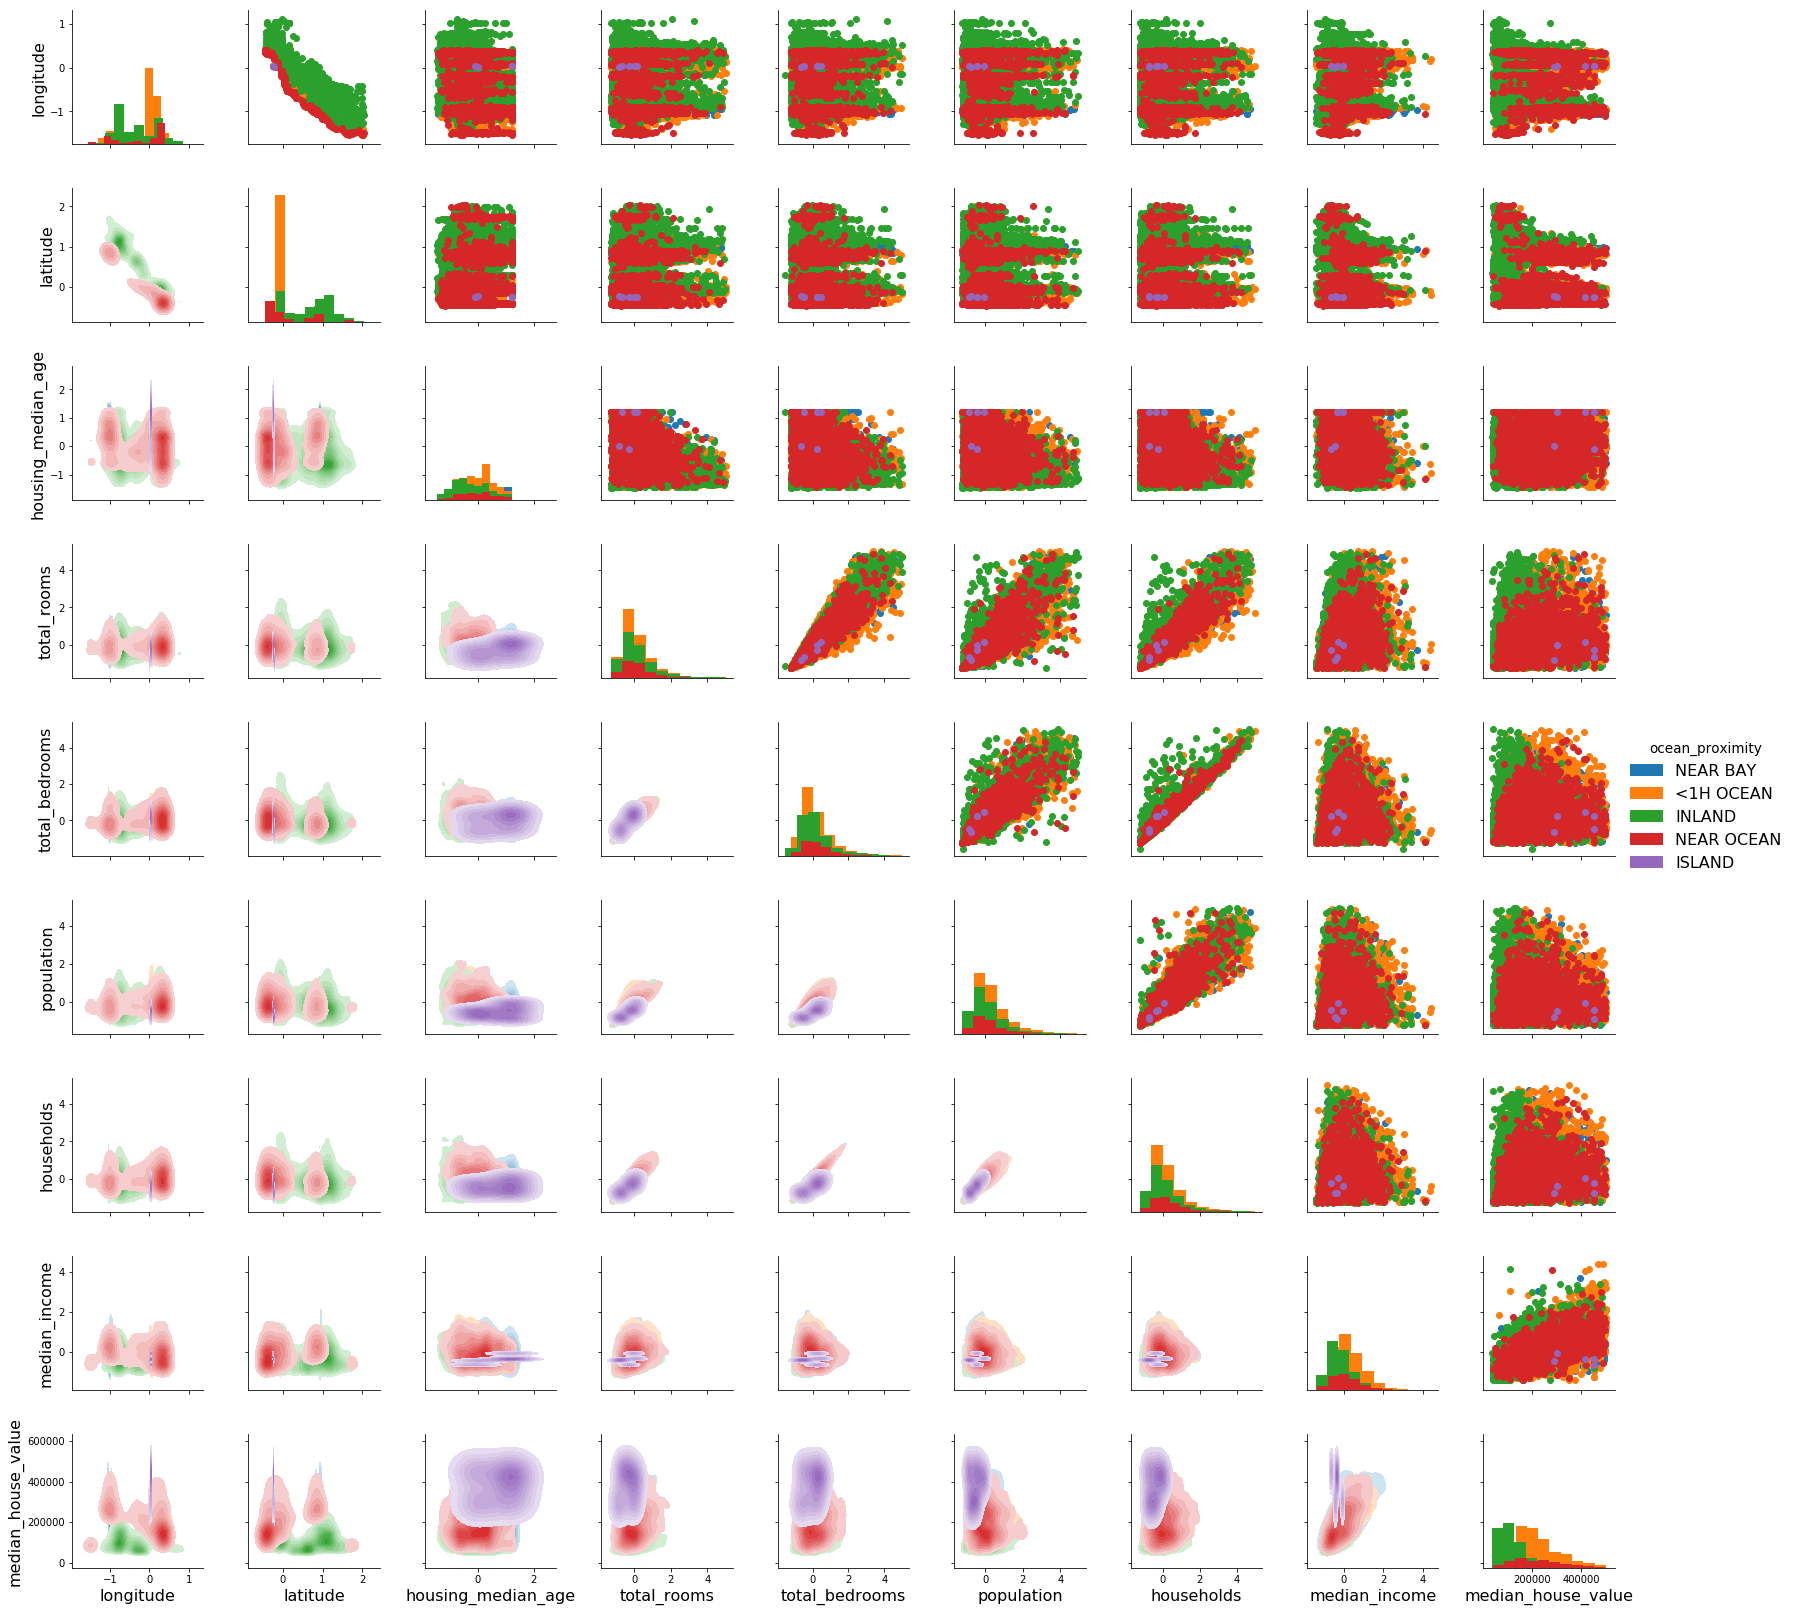

In [30]:
# Looking at the grid plots   
gridplot = sns.PairGrid(data_scaled_new, hue='ocean_proximity')
gridplot = gridplot.map_upper(plt.scatter)
gridplot = gridplot.map_diag(plt.hist)
gridplot = gridplot.map_lower(sns.kdeplot, shade=True, shade_lowest=False)
gridplot = gridplot.add_legend()

#### From the plots, we can see that Total_rooms, total_bedrooms, population and household are highly correlated. 
#### Median income seems to have a stronger predictive value for our response median_house_value. This agrees with common sense.
#### The median_house_value distribution looks logarithmic. We can try transforing the data .

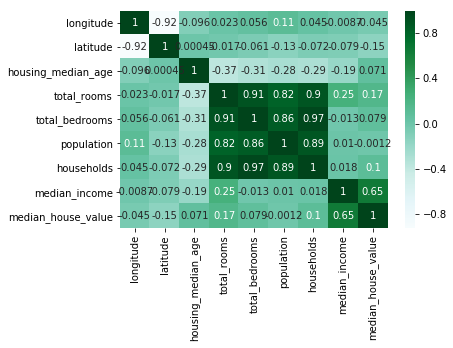

In [31]:
#Lets plot the heatmap
sns.heatmap(data_scaled_new.corr(), cmap='BuGn', annot=True)

#### We see similar observations as in the gridplot.

Lambda :0.2031858483436991


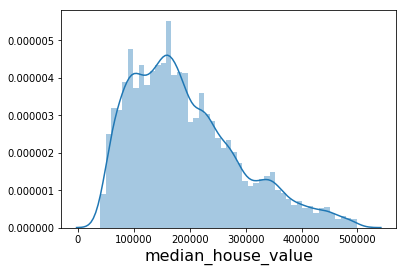

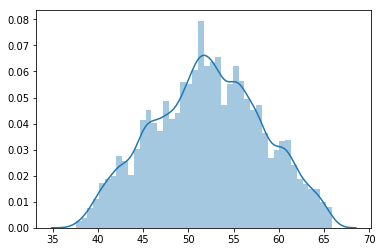

In [32]:
# splitting the data into predictors and response
predictors, response = data_scaled_new.drop(['median_house_value'], axis=1), data_scaled_new['median_house_value']

# Tranforming the response
hist, ax = plt.subplots()
ax = sns.distplot(response)

#response_new = np.sqrt(response)
response_new = stats.boxcox(response)[0]
maxlog = stats.boxcox(response)[1]
print(f'Lambda :{maxlog}')

hist, ax = plt.subplots()
ax = sns.distplot(response_new)

#### The data looks close to normal when it is transformed by using sqrt. We have to remember to square it back in the end after our prediction analysis.

## Linear Regression

In [33]:
# creating dummy variables
predictors_new = pd.get_dummies(predictors, drop_first=True)
predictors_new.reset_index(drop= True, inplace=True)
pd.Series(response_new).reset_index(drop= True, inplace=True)

#Cross Validating with 10 folds
kf = KFold(n_splits=10)
coefs = []
scores = []

for train, test in kf.split(predictors_new):
    predictors_train, predictors_test = predictors_new.iloc[train], predictors_new.iloc[test]
    response_train, response_test = response_new[train], response_new[test]
    model_lr = LinearRegression()
    model_lr.fit(predictors_train, response_train)
    coefs.append(pd.DataFrame(model_lr.coef_))
    scores.append(model_lr.score(predictors_test, response_test))
    
coefs_df = pd.concat(coefs, axis=1)
coefs_df.index = predictors_new.columns

print(f'The average variance score is {sum(scores)/len(scores)}')
lr_coefs = coefs_df.mean(axis=1)

The average variance score is 0.5391353709493509


In [34]:
# Applying regularization methods
lasso = Lasso(normalize=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(predictors_new, response_new, random_state=42)
lasso.fit(X_train, y_train)

lasso_coefs = pd.Series(lasso.coef_)
lasso_coefs.index = predictors_new.columns

In [35]:
ridge = Ridge(normalize= True, random_state=42)
ridge.fit(X_train, y_train)

ridge_coefs = pd.Series(ridge.coef_)
ridge_coefs.index = predictors_new.columns

In [36]:
en = ElasticNet(normalize= True, random_state=42)
en.fit(X_train, y_train)

en_coefs = pd.Series(ridge.coef_)
en_coefs.index = predictors_new.columns

In [37]:
Coefs = pd.DataFrame([lr_coefs, ridge_coefs, lasso_coefs, en_coefs]).transpose()
Coefs.columns = ['lr_coefs', 'ridge_coefs', 'lasso_coefs', 'en_coefs']
Coefs

,lr_coefs,ridge_coefs,lasso_coefs,en_coefs
longitude,-6.384007,-0.422320,-0.0,-0.422320
latitude,-6.083004,-0.684965,-0.0,-0.684965
housing_median_age,0.782074,0.326587,0.0,0.326587
total_rooms,-1.024158,0.342923,0.0,0.342923
total_bedrooms,2.667618,0.178691,0.0,0.178691
population,-2.282299,-0.257235,0.0,-0.257235
households,1.046481,0.229073,0.0,0.229073
median_income,5.134500,2.473368,0.0,2.473368
ocean_proximity_INLAND,-3.095284,-2.869692,-0.0,-2.869692
ocean_proximity_ISLAND,6.856813,4.706806,0.0,4.706806


## Gradient Boosting

In [38]:
gboost_cv.fit(X_train , y_train)
y_pred = gboost_cv.predict(X_test)
print(f'Variance score for Gradient boost Algorithm is: {gboost_cv.score(X_test, y_test)}')
print(f'Mean squared error of the model is: {mean_squared_error(y_test,y_pred)}')

rough_errors = np.round(np.sqrt(mean_squared_error(y_test,y_pred)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Variance score for Gradient boost Algorithm is: 0.7848054384402172
Mean squared error of the model is: 7.799822185404478
Model makes rough miscalculations of about $2.79


#### The gradient boosting after cleaning the outliers gave us a variance score of

## XGBoost  

In [39]:
xgb_cv.fit(X_train, y_train)
y_pred = xgb_cv.predict(X_test)
print(f'Variance score for Gradient boost Algorithm is: {xgb_cv.score(X_test, y_test)}')
print(f'Mean squared error of the model is: {mean_squared_error(y_test,y_pred)}')

rough_errors = np.round(np.sqrt(mean_squared_error(y_test,y_pred)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Variance score for Gradient boost Algorithm is: 0.8009627510992232
Mean squared error of the model is: 7.214193232605771
Model makes rough miscalculations of about $2.69


#### The gradient boosting after cleaning the outliers gave us a variance score of

## Neural Networks

In [40]:
epochs = 1500
batch_size = 128
mlpModel = KerasRegressor(reg_model, epochs=epochs, batch_size=batch_size, verbose=1)
mlpModel.fit(X_train, y_train)
y_pred = mlpModel.predict(X_test)
rsquared = r2_score(y_test, y_pred)

Epoch 1/1500
14475/14475 [==============================] - 7s 492us/step - loss: 203.7100 - mean_squared_error: 203.7100
Epoch 2/1500
14475/14475 [==============================] - 6s 437us/step - loss: 37.6296 - mean_squared_error: 37.6296
Epoch 3/1500
14475/14475 [==============================] - 6s 439us/step - loss: 37.5610 - mean_squared_error: 37.5610
Epoch 4/1500
14475/14475 [==============================] - ETA: 0s - loss: 37.1336 - mean_squared_error: 37.13 - 7s 458us/step - loss: 37.1406 - mean_squared_error: 37.1406
Epoch 5/1500
14475/14475 [==============================] - 6s 446us/step - loss: 35.2218 - mean_squared_error: 35.2218
Epoch 6/1500
14475/14475 [==============================] - 6s 441us/step - loss: 34.1225 - mean_squared_error: 34.1225
Epoch 7/1500
14475/14475 [==============================] - 6s 442us/step - loss: 32.9434 - mean_squared_error: 32.9434
Epoch 8/1500
14475/14475 [==============================] - 6s 437us/step - loss: 32.1778 - mean_squared

14475/14475 [==============================] - 6s 438us/step - loss: 10.8904 - mean_squared_error: 10.8904
Epoch 69/1500
14475/14475 [==============================] - 6s 444us/step - loss: 10.4663 - mean_squared_error: 10.4663
Epoch 70/1500
14475/14475 [==============================] - 6s 439us/step - loss: 10.5171 - mean_squared_error: 10.5171
Epoch 71/1500
14475/14475 [==============================] - 6s 443us/step - loss: 10.4860 - mean_squared_error: 10.4860
Epoch 72/1500
14475/14475 [==============================] - 7s 452us/step - loss: 10.2120 - mean_squared_error: 10.2120
Epoch 73/1500
14475/14475 [==============================] - 6s 434us/step - loss: 10.2101 - mean_squared_error: 10.2101
Epoch 74/1500
14475/14475 [==============================] - 6s 434us/step - loss: 10.0915 - mean_squared_error: 10.0915
Epoch 75/1500
14475/14475 [==============================] - 7s 452us/step - loss: 9.9244 - mean_squared_error: 9.9244
Epoch 76/1500
14475/14475 [=====================

14475/14475 [==============================] - 6s 447us/step - loss: 6.9375 - mean_squared_error: 6.9375
Epoch 136/1500
14475/14475 [==============================] - 6s 445us/step - loss: 6.9450 - mean_squared_error: 6.9450
Epoch 137/1500
14475/14475 [==============================] - 7s 451us/step - loss: 6.9569 - mean_squared_error: 6.9569
Epoch 138/1500
14475/14475 [==============================] - 6s 447us/step - loss: 7.0120 - mean_squared_error: 7.0120
Epoch 139/1500
14475/14475 [==============================] - 6s 446us/step - loss: 6.9272 - mean_squared_error: 6.9272
Epoch 140/1500
14475/14475 [==============================] - 6s 449us/step - loss: 6.8717 - mean_squared_error: 6.8717
Epoch 141/1500
14475/14475 [==============================] - 6s 436us/step - loss: 6.8247 - mean_squared_error: 6.8247
Epoch 142/1500
14475/14475 [==============================] - 6s 445us/step - loss: 6.9074 - mean_squared_error: 6.9074
Epoch 143/1500
14475/14475 [===========================

14475/14475 [==============================] - 6s 437us/step - loss: 5.8239 - mean_squared_error: 5.8239
Epoch 203/1500
14475/14475 [==============================] - 6s 442us/step - loss: 5.7740 - mean_squared_error: 5.7740
Epoch 204/1500
14475/14475 [==============================] - 6s 432us/step - loss: 5.7906 - mean_squared_error: 5.7906
Epoch 205/1500
14475/14475 [==============================] - 6s 437us/step - loss: 5.7404 - mean_squared_error: 5.7404
Epoch 206/1500
14475/14475 [==============================] - 6s 438us/step - loss: 5.8117 - mean_squared_error: 5.8117
Epoch 207/1500
14475/14475 [==============================] - 6s 438us/step - loss: 5.7669 - mean_squared_error: 5.7669
Epoch 208/1500
14475/14475 [==============================] - 6s 432us/step - loss: 5.8004 - mean_squared_error: 5.8004
Epoch 209/1500
14475/14475 [==============================] - 6s 441us/step - loss: 5.8540 - mean_squared_error: 5.8540
Epoch 210/1500
14475/14475 [===========================

14475/14475 [==============================] - 6s 436us/step - loss: 5.2294 - mean_squared_error: 5.2294
Epoch 269/1500
14475/14475 [==============================] - 6s 442us/step - loss: 5.2926 - mean_squared_error: 5.2926
Epoch 270/1500
14475/14475 [==============================] - 6s 440us/step - loss: 5.1188 - mean_squared_error: 5.1188
Epoch 271/1500
14475/14475 [==============================] - 6s 435us/step - loss: 5.0444 - mean_squared_error: 5.0444
Epoch 272/1500
14475/14475 [==============================] - 6s 444us/step - loss: 5.2262 - mean_squared_error: 5.2262
Epoch 273/1500
14475/14475 [==============================] - ETA: 0s - loss: 5.1442 - mean_squared_error: 5.14 - 6s 438us/step - loss: 5.1425 - mean_squared_error: 5.1425
Epoch 274/1500
14475/14475 [==============================] - 6s 444us/step - loss: 5.2249 - mean_squared_error: 5.2249
Epoch 275/1500
14475/14475 [==============================] - 6s 438us/step - loss: 5.1715 - mean_squared_error: 5.17151s -

14475/14475 [==============================] - 7s 486us/step - loss: 4.7120 - mean_squared_error: 4.7120
Epoch 335/1500
14475/14475 [==============================] - 7s 481us/step - loss: 4.6752 - mean_squared_error: 4.67520s - loss: 4.6457 - 
Epoch 336/1500
14475/14475 [==============================] - 7s 477us/step - loss: 4.8067 - mean_squared_error: 4.8067
Epoch 337/1500
14475/14475 [==============================] - 7s 477us/step - loss: 4.8760 - mean_squared_error: 4.8760
Epoch 338/1500
14475/14475 [==============================] - 7s 479us/step - loss: 4.8220 - mean_squared_error: 4.8220
Epoch 339/1500
14475/14475 [==============================] - 7s 479us/step - loss: 4.7363 - mean_squared_error: 4.7363
Epoch 340/1500
14475/14475 [==============================] - 7s 479us/step - loss: 4.7684 - mean_squared_error: 4.7684
Epoch 341/1500
14475/14475 [==============================] - 7s 477us/step - loss: 4.7499 - mean_squared_error: 4.7499
Epoch 342/1500
14475/14475 [=======

14475/14475 [==============================] - 7s 479us/step - loss: 4.5169 - mean_squared_error: 4.5169
Epoch 402/1500
14475/14475 [==============================] - 7s 479us/step - loss: 4.5056 - mean_squared_error: 4.5056
Epoch 403/1500
14475/14475 [==============================] - 7s 479us/step - loss: 4.4211 - mean_squared_error: 4.4211
Epoch 404/1500
14475/14475 [==============================] - 7s 480us/step - loss: 4.4398 - mean_squared_error: 4.43980s - loss: 4.4395 - mean_squared_error: 4.43
Epoch 405/1500
14475/14475 [==============================] - 7s 478us/step - loss: 4.4503 - mean_squared_error: 4.4503
Epoch 406/1500
14475/14475 [==============================] - 7s 476us/step - loss: 4.4822 - mean_squared_error: 4.4822
Epoch 407/1500
14475/14475 [==============================] - 7s 478us/step - loss: 4.5370 - mean_squared_error: 4.5370
Epoch 408/1500
14475/14475 [==============================] - 7s 486us/step - loss: 4.5017 - mean_squared_error: 4.5017
Epoch 409/1

14475/14475 [==============================] - 7s 473us/step - loss: 4.2213 - mean_squared_error: 4.2213
Epoch 469/1500
14475/14475 [==============================] - 7s 479us/step - loss: 4.5265 - mean_squared_error: 4.52651s
Epoch 470/1500
14475/14475 [==============================] - 7s 475us/step - loss: 4.2979 - mean_squared_error: 4.2979
Epoch 471/1500
14475/14475 [==============================] - 7s 474us/step - loss: 4.2317 - mean_squared_error: 4.2317
Epoch 472/1500
14475/14475 [==============================] - 7s 479us/step - loss: 4.2386 - mean_squared_error: 4.2386
Epoch 473/1500
14475/14475 [==============================] - 7s 481us/step - loss: 4.2775 - mean_squared_error: 4.2775
Epoch 474/1500
14475/14475 [==============================] - 7s 471us/step - loss: 4.1801 - mean_squared_error: 4.1801
Epoch 475/1500
14475/14475 [==============================] - 7s 474us/step - loss: 4.2166 - mean_squared_error: 4.21660s - loss: 4.2166 - mean_squared_error: 4.21
Epoch 476

14475/14475 [==============================] - 6s 435us/step - loss: 4.1958 - mean_squared_error: 4.1958
Epoch 536/1500
14475/14475 [==============================] - 6s 435us/step - loss: 4.1244 - mean_squared_error: 4.1244
Epoch 537/1500
14475/14475 [==============================] - 6s 440us/step - loss: 4.0504 - mean_squared_error: 4.0504
Epoch 538/1500
14475/14475 [==============================] - 7s 450us/step - loss: 4.1191 - mean_squared_error: 4.1191
Epoch 539/1500
14475/14475 [==============================] - 6s 432us/step - loss: 4.0192 - mean_squared_error: 4.0192
Epoch 540/1500
14475/14475 [==============================] - 6s 444us/step - loss: 4.0196 - mean_squared_error: 4.0196
Epoch 541/1500
14475/14475 [==============================] - 6s 432us/step - loss: 4.0058 - mean_squared_error: 4.0058
Epoch 542/1500
14475/14475 [==============================] - 6s 434us/step - loss: 4.1104 - mean_squared_error: 4.1104
Epoch 543/1500
14475/14475 [===========================

14475/14475 [==============================] - 6s 434us/step - loss: 3.9441 - mean_squared_error: 3.9441
Epoch 604/1500
14475/14475 [==============================] - 6s 445us/step - loss: 3.8838 - mean_squared_error: 3.8838
Epoch 605/1500
14475/14475 [==============================] - 6s 437us/step - loss: 3.9223 - mean_squared_error: 3.9223
Epoch 606/1500
14475/14475 [==============================] - 7s 452us/step - loss: 3.8847 - mean_squared_error: 3.8847
Epoch 607/1500
14475/14475 [==============================] - 7s 451us/step - loss: 3.9364 - mean_squared_error: 3.9364
Epoch 608/1500
14475/14475 [==============================] - 6s 443us/step - loss: 4.0164 - mean_squared_error: 4.0164
Epoch 609/1500
14475/14475 [==============================] - 6s 448us/step - loss: 3.8985 - mean_squared_error: 3.8985
Epoch 610/1500
14475/14475 [==============================] - 6s 443us/step - loss: 3.9566 - mean_squared_error: 3.9566
Epoch 611/1500
14475/14475 [===========================

14475/14475 [==============================] - 8s 524us/step - loss: 3.8140 - mean_squared_error: 3.8140
Epoch 670/1500
14475/14475 [==============================] - 8s 529us/step - loss: 3.8651 - mean_squared_error: 3.8651
Epoch 671/1500
14475/14475 [==============================] - 8s 531us/step - loss: 3.8329 - mean_squared_error: 3.8329
Epoch 672/1500
14475/14475 [==============================] - 8s 530us/step - loss: 3.8219 - mean_squared_error: 3.8219
Epoch 673/1500
14475/14475 [==============================] - 8s 529us/step - loss: 3.7489 - mean_squared_error: 3.7489
Epoch 674/1500
14475/14475 [==============================] - 8s 540us/step - loss: 3.8988 - mean_squared_error: 3.8988
Epoch 675/1500
14475/14475 [==============================] - 8s 527us/step - loss: 3.8392 - mean_squared_error: 3.8392
Epoch 676/1500
14475/14475 [==============================] - 8s 524us/step - loss: 3.8282 - mean_squared_error: 3.8282
Epoch 677/1500
14475/14475 [===========================

Epoch 737/1500
14475/14475 [==============================] - 16s 1ms/step - loss: 3.7528 - mean_squared_error: 3.7528
Epoch 738/1500
14475/14475 [==============================] - 17s 1ms/step - loss: 3.7754 - mean_squared_error: 3.7754
Epoch 739/1500
14475/14475 [==============================] - 17s 1ms/step - loss: 3.7208 - mean_squared_error: 3.7208
Epoch 740/1500
14475/14475 [==============================] - 17s 1ms/step - loss: 3.7506 - mean_squared_error: 3.7506
Epoch 741/1500
14475/14475 [==============================] - 17s 1ms/step - loss: 3.6863 - mean_squared_error: 3.6863 1s - loss: 3.6755 - 
Epoch 742/1500
14475/14475 [==============================] - 14s 995us/step - loss: 3.7650 - mean_squared_error: 3.7650s - los
Epoch 743/1500
14475/14475 [==============================] - 14s 943us/step - loss: 3.6999 - mean_squared_error: 3.6999
Epoch 744/1500
14475/14475 [==============================] - 14s 960us/step - loss: 3.6924 - mean_squared_error: 3.6924
Epoch 745/1500

14475/14475 [==============================] - 8s 564us/step - loss: 3.7361 - mean_squared_error: 3.7361
Epoch 803/1500
14475/14475 [==============================] - 9s 623us/step - loss: 3.6446 - mean_squared_error: 3.6446
Epoch 804/1500
14475/14475 [==============================] - 9s 623us/step - loss: 3.6985 - mean_squared_error: 3.6985
Epoch 805/1500
14475/14475 [==============================] - 9s 600us/step - loss: 3.5979 - mean_squared_error: 3.5979
Epoch 806/1500
14475/14475 [==============================] - 8s 566us/step - loss: 3.7008 - mean_squared_error: 3.7008
Epoch 807/1500
14475/14475 [==============================] - 8s 570us/step - loss: 3.5799 - mean_squared_error: 3.5799
Epoch 808/1500
14475/14475 [==============================] - 8s 576us/step - loss: 3.6707 - mean_squared_error: 3.6707
Epoch 809/1500
14475/14475 [==============================] - 8s 583us/step - loss: 3.6565 - mean_squared_error: 3.6565
Epoch 810/1500
14475/14475 [===========================

14475/14475 [==============================] - 6s 425us/step - loss: 3.5253 - mean_squared_error: 3.5253
Epoch 888/1500
14475/14475 [==============================] - 7s 497us/step - loss: 3.4893 - mean_squared_error: 3.4893
Epoch 889/1500
14475/14475 [==============================] - 8s 523us/step - loss: 3.5258 - mean_squared_error: 3.5258
Epoch 890/1500
14475/14475 [==============================] - 6s 413us/step - loss: 3.5475 - mean_squared_error: 3.5475
Epoch 891/1500
14475/14475 [==============================] - 6s 435us/step - loss: 3.4849 - mean_squared_error: 3.4849
Epoch 892/1500
14475/14475 [==============================] - 6s 399us/step - loss: 3.5351 - mean_squared_error: 3.5351
Epoch 893/1500
14475/14475 [==============================] - 6s 419us/step - loss: 3.6519 - mean_squared_error: 3.6519
Epoch 894/1500
14475/14475 [==============================] - 6s 433us/step - loss: 3.5498 - mean_squared_error: 3.54981s - loss: 3.5411 - mean_s - ETA
Epoch 895/1500
14475/14

14475/14475 [==============================] - 7s 518us/step - loss: 3.5167 - mean_squared_error: 3.5167
Epoch 983/1500
14475/14475 [==============================] - 8s 520us/step - loss: 3.4821 - mean_squared_error: 3.4821
Epoch 984/1500
14475/14475 [==============================] - 8s 523us/step - loss: 3.5007 - mean_squared_error: 3.5007
Epoch 985/1500
14475/14475 [==============================] - 8s 520us/step - loss: 3.5029 - mean_squared_error: 3.5029
Epoch 986/1500
14475/14475 [==============================] - 7s 516us/step - loss: 3.4869 - mean_squared_error: 3.4869
Epoch 987/1500
14475/14475 [==============================] - 8s 522us/step - loss: 3.4667 - mean_squared_error: 3.4667
Epoch 988/1500
14475/14475 [==============================] - 8s 530us/step - loss: 3.4694 - mean_squared_error: 3.4694
Epoch 989/1500
14475/14475 [==============================] - 8s 533us/step - loss: 3.4386 - mean_squared_error: 3.4386
Epoch 990/1500
14475/14475 [===========================

14475/14475 [==============================] - 7s 473us/step - loss: 3.4688 - mean_squared_error: 3.4688
Epoch 1050/1500
14475/14475 [==============================] - 7s 469us/step - loss: 3.3760 - mean_squared_error: 3.3760
Epoch 1051/1500
14475/14475 [==============================] - 7s 466us/step - loss: 3.4163 - mean_squared_error: 3.4163
Epoch 1052/1500
14475/14475 [==============================] - 7s 468us/step - loss: 3.4447 - mean_squared_error: 3.4447
Epoch 1053/1500
14475/14475 [==============================] - 7s 462us/step - loss: 3.4134 - mean_squared_error: 3.4134
Epoch 1054/1500
14475/14475 [==============================] - 7s 461us/step - loss: 3.4611 - mean_squared_error: 3.4611
Epoch 1055/1500
14475/14475 [==============================] - 7s 475us/step - loss: 3.4009 - mean_squared_error: 3.4009
Epoch 1056/1500
14475/14475 [==============================] - 7s 463us/step - loss: 3.3921 - mean_squared_error: 3.3921
Epoch 1057/1500
14475/14475 [===================

14475/14475 [==============================] - 6s 428us/step - loss: 3.3500 - mean_squared_error: 3.3500
Epoch 1117/1500
14475/14475 [==============================] - 6s 433us/step - loss: 3.3466 - mean_squared_error: 3.3466
Epoch 1118/1500
14475/14475 [==============================] - 6s 423us/step - loss: 3.3852 - mean_squared_error: 3.3852
Epoch 1119/1500
14475/14475 [==============================] - 6s 438us/step - loss: 3.3206 - mean_squared_error: 3.3206
Epoch 1120/1500
14475/14475 [==============================] - 6s 429us/step - loss: 3.3198 - mean_squared_error: 3.3198
Epoch 1121/1500
14475/14475 [==============================] - 6s 430us/step - loss: 3.3743 - mean_squared_error: 3.3743
Epoch 1122/1500
14475/14475 [==============================] - 6s 436us/step - loss: 3.3173 - mean_squared_error: 3.3173
Epoch 1123/1500
14475/14475 [==============================] - 6s 435us/step - loss: 3.3695 - mean_squared_error: 3.3695
Epoch 1124/1500
14475/14475 [===================

14475/14475 [==============================] - 6s 430us/step - loss: 3.3525 - mean_squared_error: 3.3525
Epoch 1184/1500
14475/14475 [==============================] - 6s 438us/step - loss: 3.3632 - mean_squared_error: 3.3632
Epoch 1185/1500
14475/14475 [==============================] - 6s 428us/step - loss: 3.3800 - mean_squared_error: 3.3800
Epoch 1186/1500
14475/14475 [==============================] - 6s 428us/step - loss: 3.2449 - mean_squared_error: 3.2449
Epoch 1187/1500
14475/14475 [==============================] - 7s 450us/step - loss: 3.3255 - mean_squared_error: 3.3255
Epoch 1188/1500
14475/14475 [==============================] - 6s 431us/step - loss: 3.2524 - mean_squared_error: 3.2524
Epoch 1189/1500
14475/14475 [==============================] - 6s 434us/step - loss: 3.2710 - mean_squared_error: 3.2710
Epoch 1190/1500
14475/14475 [==============================] - 6s 429us/step - loss: 3.3050 - mean_squared_error: 3.3050
Epoch 1191/1500
14475/14475 [===================

14475/14475 [==============================] - 6s 426us/step - loss: 3.3812 - mean_squared_error: 3.3812
Epoch 1251/1500
14475/14475 [==============================] - 6s 432us/step - loss: 3.2840 - mean_squared_error: 3.2840
Epoch 1252/1500
14475/14475 [==============================] - 6s 433us/step - loss: 3.2792 - mean_squared_error: 3.2792
Epoch 1253/1500
14475/14475 [==============================] - 6s 433us/step - loss: 3.2532 - mean_squared_error: 3.2532
Epoch 1254/1500
14475/14475 [==============================] - 6s 434us/step - loss: 3.3117 - mean_squared_error: 3.3117
Epoch 1255/1500
14475/14475 [==============================] - 6s 426us/step - loss: 3.2309 - mean_squared_error: 3.2309
Epoch 1256/1500
14475/14475 [==============================] - 6s 443us/step - loss: 3.2868 - mean_squared_error: 3.2868
Epoch 1257/1500
14475/14475 [==============================] - 6s 434us/step - loss: 3.2625 - mean_squared_error: 3.2625
Epoch 1258/1500
14475/14475 [===================

14475/14475 [==============================] - 6s 430us/step - loss: 3.1863 - mean_squared_error: 3.1863
Epoch 1318/1500
14475/14475 [==============================] - 6s 445us/step - loss: 3.2121 - mean_squared_error: 3.2121
Epoch 1319/1500
14475/14475 [==============================] - 6s 446us/step - loss: 3.2682 - mean_squared_error: 3.2682
Epoch 1320/1500
14475/14475 [==============================] - 6s 429us/step - loss: 3.2530 - mean_squared_error: 3.2530
Epoch 1321/1500
14475/14475 [==============================] - 6s 440us/step - loss: 3.2859 - mean_squared_error: 3.2859
Epoch 1322/1500
14475/14475 [==============================] - 6s 431us/step - loss: 3.2679 - mean_squared_error: 3.2679
Epoch 1323/1500
14475/14475 [==============================] - 6s 427us/step - loss: 3.2647 - mean_squared_error: 3.2647
Epoch 1324/1500
14475/14475 [==============================] - 6s 433us/step - loss: 3.1968 - mean_squared_error: 3.1968
Epoch 1325/1500
14475/14475 [===================

14475/14475 [==============================] - 6s 434us/step - loss: 3.1813 - mean_squared_error: 3.1813
Epoch 1385/1500
14475/14475 [==============================] - 6s 430us/step - loss: 3.1660 - mean_squared_error: 3.1660
Epoch 1386/1500
14475/14475 [==============================] - 6s 434us/step - loss: 3.1424 - mean_squared_error: 3.1424
Epoch 1387/1500
14475/14475 [==============================] - 6s 438us/step - loss: 3.2606 - mean_squared_error: 3.2606
Epoch 1388/1500
14475/14475 [==============================] - 6s 436us/step - loss: 3.2387 - mean_squared_error: 3.2387
Epoch 1389/1500
14475/14475 [==============================] - 6s 389us/step - loss: 3.2435 - mean_squared_error: 3.2435
Epoch 1390/1500
14475/14475 [==============================] - 6s 406us/step - loss: 3.2934 - mean_squared_error: 3.2934
Epoch 1391/1500
14475/14475 [==============================] - 6s 440us/step - loss: 3.2567 - mean_squared_error: 3.2567
Epoch 1392/1500
14475/14475 [===================

14475/14475 [==============================] - 6s 435us/step - loss: 3.1337 - mean_squared_error: 3.1337
Epoch 1452/1500
14475/14475 [==============================] - 6s 437us/step - loss: 3.1012 - mean_squared_error: 3.1012
Epoch 1453/1500
14475/14475 [==============================] - 6s 426us/step - loss: 3.1637 - mean_squared_error: 3.1637
Epoch 1454/1500
14475/14475 [==============================] - 6s 436us/step - loss: 3.1015 - mean_squared_error: 3.1015
Epoch 1455/1500
14475/14475 [==============================] - 6s 428us/step - loss: 3.1885 - mean_squared_error: 3.1885
Epoch 1456/1500
14475/14475 [==============================] - 6s 433us/step - loss: 3.2033 - mean_squared_error: 3.2033
Epoch 1457/1500
14475/14475 [==============================] - 6s 437us/step - loss: 3.1318 - mean_squared_error: 3.1318
Epoch 1458/1500
14475/14475 [==============================] - 6s 434us/step - loss: 3.2116 - mean_squared_error: 3.2116
Epoch 1459/1500
14475/14475 [===================

In [41]:
print(f'Model coefficient of determination, R_square = {r2_score(y_test, y_pred)}')
y_test_inv = inv_boxcox(y_test, maxlog)
y_pred_inv = inv_boxcox(y_pred, maxlog)
print(f'MSE : {mean_squared_error(y_test_inv,y_pred_inv)}')
print(f'MSE : {mean_squared_error(y_test,y_pred)}')
rough_errors = np.round(np.sqrt(mean_squared_error(y_test_inv,y_pred_inv)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Model coefficient of determination, R_square = 0.8200855325701493
MSE : 1967060228.217713
MSE : 6.521079549423148
Model makes rough miscalculations of about $44351.55


#### Even after removing the outliers, we notice that there is not much improvement in prediction accuracy. We can now try to do some feature engineering, which might improve our predictions.

## Feature Engineering

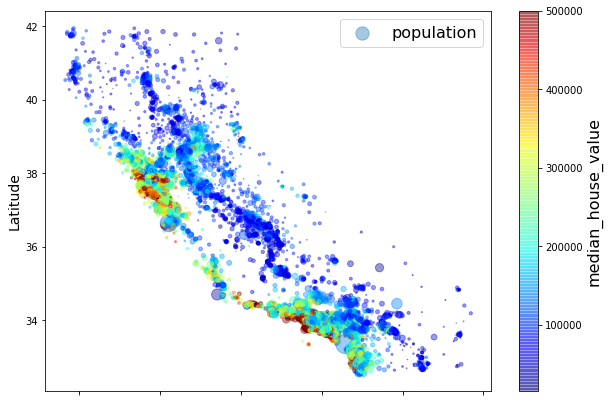

In [42]:
data_cleaned.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
                  s=data_cleaned['population']/100, label='population', 
                  figsize=(10,7),c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()

#### We can clearly see that there are areas where the population is huge and there are areas where, the houses are really expensive. We can extract a few features like:
#### -Distance from the major cities like Los Angeles, San Francisco, San Diego etc
#### -Distance from the nearest cities

In [43]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# For extracting distance to the major cities -San Francisco and Los Angeles
geolocator = Nominatim(timeout=3)

In [44]:
data_cleaned['lat_long'] = data_cleaned['latitude'].astype(str) + ',' + data_cleaned['longitude'].astype(str)
data_cleaned.shape

(20640, 11)

In [45]:
# For extracting distance from populated cities
#Historical population data for cities in California (including the year 1990, which is the year the original housing price 
#data was collected  : http://www.dof.ca.gov/Reports/Demographic_Reports/documents/2010-1850_STCO_IncCities-FINAL.xls
populated_cities_raw = pd.read_csv('cal_populations_county.csv')
populated_cities_raw.head()

,County,City,Incorportation_date,pop_april_1980,pop_april_1990,pop_april_2000,pop_april_2010
0,San Bernardino,Adelanto,1970,2164.0,8517,18130,31765
1,Los Angeles,Agoura Hills,1982,NaN,20390,20537,20330
2,Alameda,Alameda,1854,63852.0,76459,72259,73812
3,Alameda,Albany,1908,15130.0,16327,16444,18539
4,Los Angeles,Alhambra,1903,64767.0,82106,85804,83089


In [46]:
#Calculating mean population and defining highly populated cities as cities greater than mean population
populated_cities = populated_cities_raw.sort_values(by='pop_april_1990', ascending=False).reset_index(drop=True).head(51)
populated_cities

,County,City,Incorportation_date,pop_april_1980,pop_april_1990,pop_april_2000,pop_april_2010
0,Los Angeles,Los Angeles,1850,2968579.0,3485398,3694742,3792621
1,San Diego,San Diego,1850,875538.0,1110549,1223400,1307402
2,Santa Clara,San Jose,1850,629531.0,782248,894943,945942
3,San Francisco,San Francisco,1850,678974.0,723959,776733,805235
4,Los Angeles,Long Beach,i. 1888/ d.1896/ \nri. 1897,361355.0,429433,461522,462257
5,Alameda,Oakland,1852,339337.0,372242,399484,390724
6,Sacramento,Sacramento,1850,275741.0,369365,407018,466488
7,Fresno,Fresno,1885,217129.0,354202,427652,494665
8,Orange,Santa Ana,1886,204023.0,293742,337977,324528
9,Orange,Anaheim,1876,219494.0,266406,328014,336265


In [47]:
# For extracting longitude and latitude of the hihly populated cities
latitude = []
longitude = []
for i in range (populated_cities.shape[0]):
    location = geolocator.geocode(populated_cities.City[i])
    latitude.append(location.latitude)
    longitude.append(location.longitude)

In [48]:
populated_cities['latitude'] = latitude
populated_cities['longitude'] = longitude
populated_cities['lat_long'] = populated_cities['latitude'].astype(str) + ',' + populated_cities['longitude'].astype(str)

In [49]:
populated_cities.head()

,County,City,Incorportation_date,pop_april_1980,pop_april_1990,pop_april_2000,pop_april_2010,latitude,longitude,lat_long
0,Los Angeles,Los Angeles,1850,2968579.0,3485398,3694742,3792621,34.053683,-118.242767,"34.0536834,-118.2427669"
1,San Diego,San Diego,1850,875538.0,1110549,1223400,1307402,32.717421,-117.162771,"32.7174209,-117.1627714"
2,Santa Clara,San Jose,1850,629531.0,782248,894943,945942,37.336191,-121.890583,"37.3361905,-121.8905833"
3,San Francisco,San Francisco,1850,678974.0,723959,776733,805235,37.779281,-122.419236,"37.7792808,-122.4192363"
4,Los Angeles,Long Beach,i. 1888/ d.1896/ \nri. 1897,361355.0,429433,461522,462257,33.785389,-118.158049,"33.78538945,-118.158049315311"


In [50]:
nearest_city = []
nearest_city_lat_long = []
nearest_distance = []

for location in range(data_cleaned.shape[0]):
    mindistance = 3000 #arbitrarily large value
    for city in range(populated_cities.shape[0]):
        distance = (round(geodesic(data_cleaned['lat_long'][location], populated_cities['lat_long'][city]).miles,2))
        if distance < mindistance:
            mindistance = distance
            closest_city = populated_cities['City'][city]
            closest_city_lat_long = populated_cities['lat_long'][city]
    nearest_city.append(closest_city)
    nearest_city_lat_long.append(closest_city_lat_long)
    nearest_distance.append(mindistance)

In [51]:
data_cleaned['nearest_city'] = nearest_city
data_cleaned['distance_to_nearest_city'] = nearest_distance
data_cleaned.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,lat_long,nearest_city,distance_to_nearest_city
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,"37.88,-122.23",Berkeley,2.43
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,"37.86,-122.22",Berkeley,2.99
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,"37.85,-122.24",Berkeley,2.30
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,"37.85,-122.25",Berkeley,1.90
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,"37.85,-122.25",Berkeley,1.90
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,"37.85,-122.25",Berkeley,1.90
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,"37.84,-122.25",Berkeley,2.47
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,"37.84,-122.25",Berkeley,2.47
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,"37.84,-122.26",Berkeley,2.24
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,"37.84,-122.25",Berkeley,2.47


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 <a list of 45 Text xticklabel objects>)

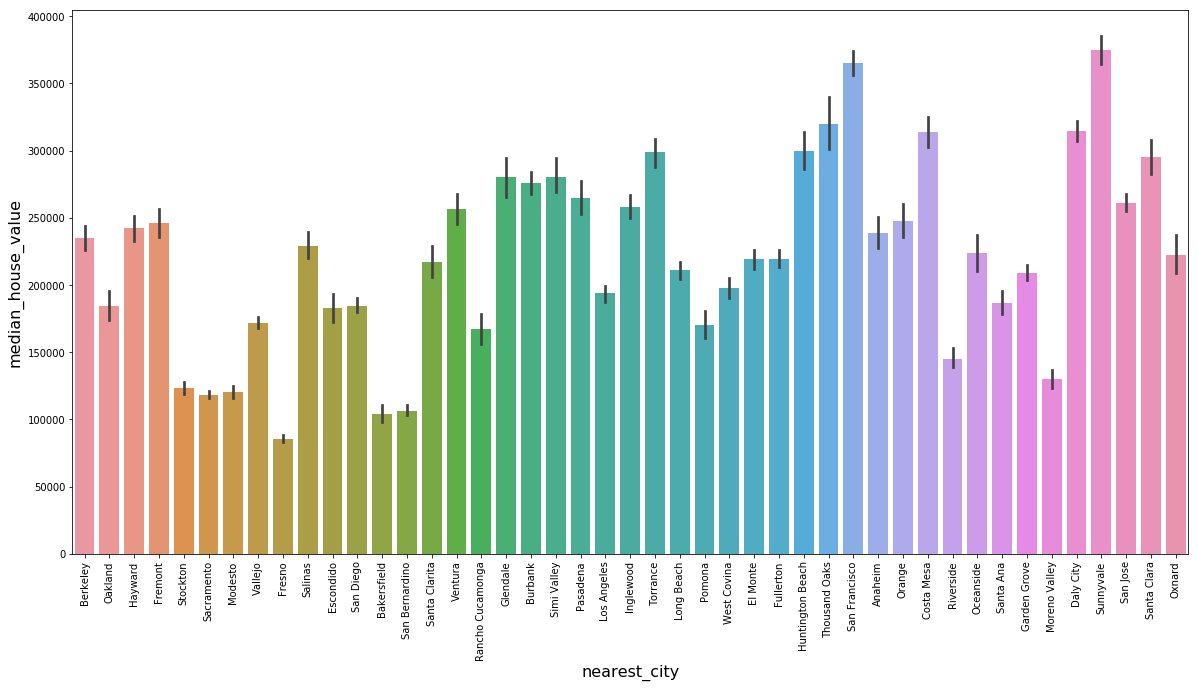

In [52]:
fig, ax = plt.subplots(figsize = (20,10))
ax = sns.barplot(x='nearest_city', y='median_house_value', data=data_cleaned)
plt.xticks(rotation=90)

In [53]:
#now lets find the expensive cities
expensive_cities_list = data_cleaned.groupby('nearest_city')['median_house_value'].mean()\
                        .sort_values(ascending=False).head(10).index.tolist()
expensive_cities = populated_cities[populated_cities.City.isin(expensive_cities_list)].reset_index(drop=True)

In [54]:
expensive_city = []
expensive_city_lat_long = []
expensive_city_distance = []

for location in range(data_cleaned.shape[0]):
    mindistance = 3000 #arbitrarily large value
    for city in range(expensive_cities.shape[0]):
        distance = (round(geodesic(data_cleaned['lat_long'][location], expensive_cities['lat_long'][city]).miles,2))
        if distance < mindistance:
            mindistance = distance
            closest_city = expensive_cities['City'][city]
            closest_city_lat_long = expensive_cities['lat_long'][city]
    expensive_city.append(closest_city)
    expensive_city_lat_long.append(closest_city_lat_long)
    expensive_city_distance.append(mindistance)

In [55]:
data_cleaned['expensive_city'] = expensive_city
data_cleaned['expensive_city_distance'] = expensive_city_distance
data_cleaned.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,lat_long,nearest_city,distance_to_nearest_city,expensive_city,expensive_city_distance
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,"37.88,-122.23",Berkeley,2.43,San Francisco,12.47
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,"37.86,-122.22",Berkeley,2.99,San Francisco,12.24
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,"37.85,-122.24",Berkeley,2.30,San Francisco,10.95
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,"37.85,-122.25",Berkeley,1.90,San Francisco,10.47
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,"37.85,-122.25",Berkeley,1.90,San Francisco,10.47
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,"37.85,-122.25",Berkeley,1.90,San Francisco,10.47
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,"37.84,-122.25",Berkeley,2.47,San Francisco,10.16
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,"37.84,-122.25",Berkeley,2.47,San Francisco,10.16
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,"37.84,-122.26",Berkeley,2.24,San Francisco,9.67
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,"37.84,-122.25",Berkeley,2.47,San Francisco,10.16


In [56]:
data_cleaned['mean_rooms'] = data_cleaned['total_rooms']/data_cleaned['households']
data_cleaned['mean_bedrooms'] = data_cleaned['total_bedrooms']/data_cleaned['households']
data_cleaned['mean_population'] = data_cleaned['population']/data_cleaned['households']

In [57]:
data_cleaned.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,lat_long,nearest_city,distance_to_nearest_city,expensive_city,expensive_city_distance,mean_rooms,mean_bedrooms,mean_population
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,"37.88,-122.23",Berkeley,2.43,San Francisco,12.47,6.984127,1.023810,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,"37.86,-122.22",Berkeley,2.99,San Francisco,12.24,6.238137,0.971880,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,"37.85,-122.24",Berkeley,2.30,San Francisco,10.95,8.288136,1.073446,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,"37.85,-122.25",Berkeley,1.90,San Francisco,10.47,5.817352,1.073059,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,"37.85,-122.25",Berkeley,1.90,San Francisco,10.47,6.281853,1.081081,2.181467


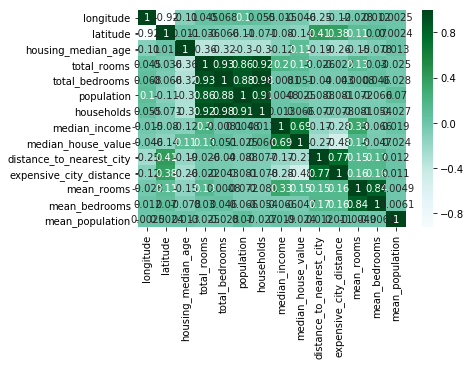

In [58]:
sns.heatmap(data_cleaned.corr(), cmap='BuGn', annot=True)

In [59]:
unwanted = ['longitude', 'latitude', 'total_rooms', 'total_bedrooms', 'population', 'households',
            'lat_long', 'expensive_city', 'nearest_city']
wanted = list(set(data_cleaned.columns)-set(unwanted))
data_with_features = data_cleaned[wanted]
data_with_features.shape

(20640, 9)

In [60]:
scaler = RobustScaler()
pred, res = data_with_features.drop(['median_house_value', 'ocean_proximity'], axis=1), data_with_features['median_house_value']
pred_scaled = pd.DataFrame(scaler.fit_transform(pred), columns = pred.columns.tolist())

pred_scaled = pred_scaled.join(data_cleaned['ocean_proximity'])
data_scaled = pred_scaled.join(data_cleaned['median_house_value'])

In [61]:
print(data_scaled[data_scaled['mean_rooms'] >= 4].shape)
print(data_scaled[data_scaled['mean_bedrooms'] >= 4].shape)
print(data_scaled[data_scaled['median_income'] >= 4].shape)
print(data_scaled[data_scaled['mean_population'] >= 4].shape)
print(data_scaled[data_scaled['distance_to_nearest_city'] >= 5].shape)
print(data_scaled[data_scaled['median_house_value'] == 500000].shape)
print(data_scaled[data_scaled['median_house_value'] <= 40000].shape)

(150, 9)
(619, 9)
(104, 9)
(97, 9)
(1400, 9)
(27, 9)
(44, 9)


In [62]:
data_scaled_new = data_scaled[(data_scaled['mean_rooms'] <= 3) & (abs(data_scaled['mean_bedrooms']) <= 3) &
                             (data_scaled['median_income'] <= 3) & (data_scaled['mean_population'] <= 3) & 
                             (data_scaled['distance_to_nearest_city'] <= 5) &
                             (data_scaled['median_house_value'] < 500001) & (data_scaled['median_house_value'] > 40000)]
data_scaled_new.shape

(17510, 9)

In [63]:
pred_new_plot, res_new_plot = data_scaled_new.drop(['median_house_value', 'ocean_proximity'], axis=1), \
                    data_scaled_new['median_house_value']

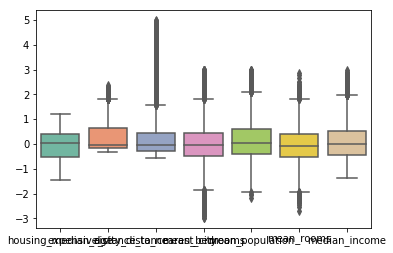

In [64]:
hist, ax = plt.subplots()
ax = sns.boxplot(data=pred_new_plot, palette='Set2')

Lambda :0.25766803566254487


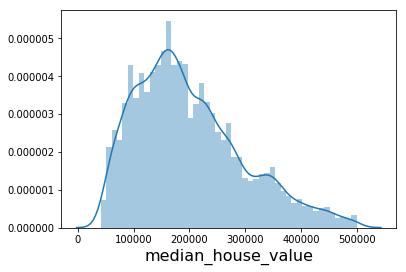

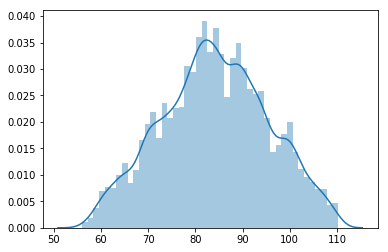

In [65]:
hist, ax = plt.subplots()
ax = sns.distplot(res_new_plot)

res_new = pd.Series(stats.boxcox(res_new_plot)[0])
maxlog = stats.boxcox(res_new_plot)[1]
print(f'Lambda :{maxlog}')

hist, ax = plt.subplots()
ax = sns.distplot(res_new)

pred_new = data_scaled_new.drop(['median_house_value'], axis=1)

## Linear Regression

In [66]:
#creating dummies for categorical columns
pred_new = pd.get_dummies(pred_new, drop_first=True)
#splitting the data into train and test splits
pred_train, pred_test, res_train, res_test = train_test_split(pred_new, res_new, random_state=42)

In [67]:
#Fit model and predict
model = LinearRegression()
model.fit(pred_train, res_train)
res_pred = model.predict(pred_test)

#Look at the results
values = np.append(model.intercept_, model.coef_)
names = np.append('Intercept', pred_new.columns)
results = pd.DataFrame(values, index=names, columns=['Coef'])
print(results)

                                 Coef
Intercept                   86.520929
housing_median_age           0.994469
expensive_city_distance     -6.247414
distance_to_nearest_city     0.773762
mean_bedrooms                0.772386
mean_population             -3.371891
mean_rooms                  -0.857445
median_income                9.278680
ocean_proximity_INLAND      -5.225245
ocean_proximity_ISLAND       8.335423
ocean_proximity_NEAR BAY    -1.219642
ocean_proximity_NEAR OCEAN   3.009709


In [68]:
print(f'Model coefficient of determination, R_square = {r2_score(res_test, res_pred)}')
res_test_inv = inv_boxcox(res_test, maxlog)
res_pred_inv = inv_boxcox(res_pred, maxlog)
print(f'MSE : {mean_squared_error(res_test_inv,res_pred_inv)}')
rough_errors = np.round(np.sqrt(mean_squared_error(res_test_inv,res_pred_inv)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Model coefficient of determination, R_square = 0.7115661231016647
MSE : 3046296707.447942
Model makes rough miscalculations of about $55193.27


#### We can clearly see that R_squared and MSE improved by ~7% by feature extraction.

In [69]:
ridge = Ridge(normalize= True, random_state=42)
ridge.fit(pred_train, res_train)

ridge_coefs = pd.Series(ridge.coef_)
ridge_coefs.index = pred_new.columns
ridge_coefs

housing_median_age            0.150794
expensive_city_distance      -3.658944
distance_to_nearest_city     -0.373519
mean_bedrooms                -0.156281
mean_population              -1.893570
mean_rooms                    1.370325
median_income                 3.937371
ocean_proximity_INLAND       -4.404061
ocean_proximity_ISLAND        6.145024
ocean_proximity_NEAR BAY      0.489433
ocean_proximity_NEAR OCEAN    1.911148
dtype: float64

In [110]:
pred_high = pred_new.drop(['mean_bedrooms', 'distance_to_nearest_city','housing_median_age'], axis=1)

pred_train_1, pred_test_1, res_train_1, res_test_1 = train_test_split(pred_high, res_new, random_state=42)

#Fit model and predict
lr = LinearRegression()
lr.fit(pred_train_1, res_train_1)
res_pred_1 = lr.predict(pred_test_1)

#Look at the results
values = np.append(lr.intercept_, lr.coef_)
names = np.append('Intercept', pred_high.columns)
results = pd.DataFrame(values, index=names, columns=['Coef'])
print(results)

                                 Coef
Intercept                   86.880220
expensive_city_distance     -6.031333
mean_population             -3.508095
mean_rooms                  -0.137525
median_income                8.281737
ocean_proximity_INLAND      -5.415911
ocean_proximity_ISLAND      11.107627
ocean_proximity_NEAR BAY    -1.025010
ocean_proximity_NEAR OCEAN   3.009919


In [71]:
print(f'Model coefficient of determination, R_square = {r2_score(res_test_1, res_pred_1)}')
res_test_inv1 = inv_boxcox(res_test_1, maxlog)
res_pred_inv1 = inv_boxcox(res_pred_1, maxlog)
print(f'MSE : {mean_squared_error(res_test_inv1,res_pred_inv1)}')
rough_errors = np.round(np.sqrt(mean_squared_error(res_test_inv1,res_pred_inv1)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Model coefficient of determination, R_square = 0.7054796155415188
MSE : 3149277041.3404284
Model makes rough miscalculations of about $56118.42


## Random Forests

In [72]:
#Using Random forest regressor
rforest = RandomForestRegressor(random_state=42)

#Performing a randomized search for finding best parameters
param_dist = {'n_estimators': range(500,1500,500),
              'max_depth': range(1,4,1),
              'max_features': range(1,4,1),
              'min_samples_split': range(500,2000,500)
             }
rforest_cv = RandomizedSearchCV(rforest, param_distributions=param_dist, cv=10, scoring='explained_variance')

In [73]:
rforest_cv.fit(pred_train, res_train)
rforest_cv

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': range(500, 1500, 500), 'max_depth': range(1, 4), 'max_features': range(1, 4), 'min_samples_split': range(500, 2000, 500)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='explained_variance',
          verbose=0)

In [74]:
res_pred = rforest_cv.predict(pred_test)
print(rforest_cv.score(pred_test, res_test))
best_pred_new = rforest_cv.best_estimator_
best_pred_new

0.5427975073897295


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=500, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=None, oob_score=False,
           random_state=42, verbose=0, warm_start=False)

In [75]:
feature_importances = pd.DataFrame(best_pred_new.feature_importances_ ,
                                   index = pred_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

Text(0, 0.5, 'Feature Importance')

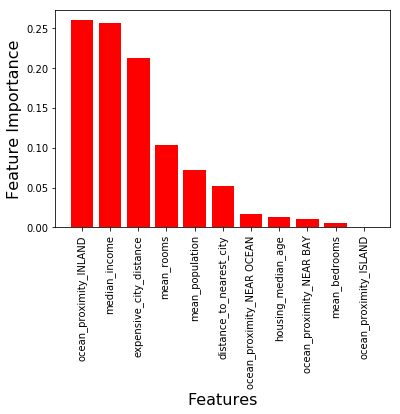

In [76]:
plt.bar(feature_importances.index, feature_importances.importance, color = "red")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.ylabel("Feature Importance")

#### The model has only 59% accuracy, hence we cannot trust the feature importance.

## Support Vector Machines

In [77]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf')

In [78]:
svr_rbf.fit(pred_train, res_train)
res_pred = svr_rbf.predict(pred_test)
print(f'Variance score for Gradient boost Algorithm is: {svr_rbf.score(pred_test, res_test)}')
res_test_inv = inv_boxcox(res_test, maxlog)
res_pred_inv = inv_boxcox(res_pred, maxlog)
print(f'MSE : {mean_squared_error(res_test_inv,res_pred_inv)}')
rough_errors = np.round(np.sqrt(mean_squared_error(res_test_inv,res_pred_inv)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Variance score for Gradient boost Algorithm is: 0.762503579975567
MSE : 2564282981.1556444
Model makes rough miscalculations of about $50638.75


#### Support Vector Machines gave us a variance score of 76.2%

## Gradient Boosting

In [79]:
# Using gradient boosting
gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, max_features=3)

param_dist = {'n_estimators': [1000,1500],
              'learning_rate': [0.01,0.001],
              'max_depth': [1,2,3,4],
              'max_features': [2,3,4]
             }

gboost_cv = RandomizedSearchCV(gboost, param_distributions=param_dist, cv=10)

In [80]:
gboost_cv.fit(pred_train, res_train)
res_pred = gboost_cv.predict(pred_test)

In [81]:
print(f'Variance score for Gradient boost Algorithm is: {gboost_cv.score(pred_test, res_test)}')
res_test_inv = inv_boxcox(res_test, maxlog)
res_pred_inv = inv_boxcox(res_pred, maxlog)
print(f'MSE : {mean_squared_error(res_test_inv,res_pred_inv)}')
rough_errors = np.round(np.sqrt(mean_squared_error(res_test_inv,res_pred_inv)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Variance score for Gradient boost Algorithm is: 0.791670140097518
MSE : 2266378262.3580303
Model makes rough miscalculations of about $47606.49


#### The variance score for the gradient boost algorithm is  79%

## XG Boost

In [82]:
# Using XG boosting
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01)
param_dist = {'n_estimators': [1000,1500,2000],
              'learning_rate': [0.01,0.001],
              'max_depth': [2,3,4]
             }
xgb_cv = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=10)

In [83]:
xgb_cv.fit(pred_train, res_train)
res_pred = xgb_cv.predict(pred_test)

In [84]:
print(f'Variance score for Gradient boost Algorithm is: {xgb_cv.score(pred_test, res_test)}')
res_test_inv = inv_boxcox(res_test, maxlog)
res_pred_inv = inv_boxcox(res_pred, maxlog)
print(f'MSE : {mean_squared_error(res_test_inv,res_pred_inv)}')
rough_errors = np.round(np.sqrt(mean_squared_error(res_test_inv,res_pred_inv)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Variance score for Gradient boost Algorithm is: 0.8055809677290491
MSE : 2096687336.6642008
Model makes rough miscalculations of about $45789.6


## Neural Networks

In [97]:
# Using Neural Nets
def reg_model():
    network = keras.models.Sequential()
    layer_1 = Dense(512, input_dim=11, activation= 'tanh', name='layer-1')
    layer_2 = Dense(512, activation='tanh', name='layer-2')
    layer_3 = Dense(512, activation='tanh', name='layer-3')
    layer_4 = Dense(1, name='output-layer')
    network.add(layer_1)
    network.add(Dropout(0.2))
    network.add(layer_2)
    network.add(Dropout(0.2))
    network.add(layer_3)
    network.add(Dropout(0.2))
    network.add(layer_4)
    network.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mse'])
    return network

model = reg_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer-1 (Dense)              (None, 512)               6144      
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
layer-2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
layer-3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
output-layer (Dense)         (None, 1)                 513       
Total para

In [102]:
epochs = 1000
batch_size = 128
mlpModel = KerasRegressor(reg_model, epochs=epochs, batch_size=batch_size, verbose=1)
mlpModel.fit(pred_train, res_train)
res_pred = mlpModel.predict(pred_test)
rsquared = r2_score(res_test, res_pred)

Epoch 1/1000
13132/13132 [==============================] - 3s 209us/step - loss: 1807.9539 - mean_squared_error: 1807.9539
Epoch 2/1000
13132/13132 [==============================] - 2s 127us/step - loss: 157.1086 - mean_squared_error: 157.1086
Epoch 3/1000
13132/13132 [==============================] - 2s 130us/step - loss: 133.8061 - mean_squared_error: 133.8061
Epoch 4/1000
13132/13132 [==============================] - 2s 139us/step - loss: 133.3577 - mean_squared_error: 133.3577
Epoch 5/1000
13132/13132 [==============================] - 2s 124us/step - loss: 132.6994 - mean_squared_error: 132.6994
Epoch 6/1000
13132/13132 [==============================] - 2s 133us/step - loss: 133.8843 - mean_squared_error: 133.8843
Epoch 7/1000
13132/13132 [==============================] - 2s 122us/step - loss: 132.0465 - mean_squared_error: 132.0465
Epoch 8/1000
13132/13132 [==============================] - 1s 103us/step - loss: 133.0544 - mean_squared_error: 133.0544
Epoch 9/1000
13132/131

13132/13132 [==============================] - 2s 115us/step - loss: 133.2168 - mean_squared_error: 133.2168
Epoch 68/1000
13132/13132 [==============================] - 1s 113us/step - loss: 133.3314 - mean_squared_error: 133.3314
Epoch 69/1000
13132/13132 [==============================] - 2s 125us/step - loss: 132.7138 - mean_squared_error: 132.7138
Epoch 70/1000
13132/13132 [==============================] - 2s 116us/step - loss: 133.0720 - mean_squared_error: 133.0720
Epoch 71/1000
13132/13132 [==============================] - 2s 117us/step - loss: 132.3970 - mean_squared_error: 132.3970
Epoch 72/1000
13132/13132 [==============================] - 2s 117us/step - loss: 133.0710 - mean_squared_error: 133.0710
Epoch 73/1000
13132/13132 [==============================] - 2s 123us/step - loss: 133.1907 - mean_squared_error: 133.1907
Epoch 74/1000
13132/13132 [==============================] - 2s 121us/step - loss: 133.3583 - mean_squared_error: 133.3583
Epoch 75/1000
13132/13132 [===

13132/13132 [==============================] - 1s 112us/step - loss: 29.7542 - mean_squared_error: 29.7542
Epoch 133/1000
13132/13132 [==============================] - 1s 112us/step - loss: 29.6277 - mean_squared_error: 29.6277
Epoch 134/1000
13132/13132 [==============================] - 1s 111us/step - loss: 29.5434 - mean_squared_error: 29.5434
Epoch 135/1000
13132/13132 [==============================] - 1s 113us/step - loss: 29.3029 - mean_squared_error: 29.3029
Epoch 136/1000
13132/13132 [==============================] - 2s 115us/step - loss: 29.0695 - mean_squared_error: 29.0695
Epoch 137/1000
13132/13132 [==============================] - 1s 112us/step - loss: 28.6564 - mean_squared_error: 28.6564
Epoch 138/1000
13132/13132 [==============================] - 1s 114us/step - loss: 29.0639 - mean_squared_error: 29.0639
Epoch 139/1000
13132/13132 [==============================] - 1s 113us/step - loss: 29.2555 - mean_squared_error: 29.2555
Epoch 140/1000
13132/13132 [===========

13132/13132 [==============================] - 2s 121us/step - loss: 23.9881 - mean_squared_error: 23.9881
Epoch 200/1000
13132/13132 [==============================] - 2s 153us/step - loss: 23.9782 - mean_squared_error: 23.9782
Epoch 201/1000
13132/13132 [==============================] - 2s 130us/step - loss: 24.3029 - mean_squared_error: 24.3029
Epoch 202/1000
13132/13132 [==============================] - 2s 136us/step - loss: 24.1823 - mean_squared_error: 24.1823
Epoch 203/1000
13132/13132 [==============================] - 1s 113us/step - loss: 23.6845 - mean_squared_error: 23.6845
Epoch 204/1000
13132/13132 [==============================] - 2s 118us/step - loss: 23.8698 - mean_squared_error: 23.8698
Epoch 205/1000
13132/13132 [==============================] - 2s 115us/step - loss: 24.2665 - mean_squared_error: 24.2665
Epoch 206/1000
13132/13132 [==============================] - 2s 114us/step - loss: 23.7804 - mean_squared_error: 23.7804
Epoch 207/1000
13132/13132 [===========

Epoch 266/1000
13132/13132 [==============================] - 2s 120us/step - loss: 22.1197 - mean_squared_error: 22.1197
Epoch 267/1000
13132/13132 [==============================] - 2s 122us/step - loss: 21.9799 - mean_squared_error: 21.9799
Epoch 268/1000
13132/13132 [==============================] - 2s 117us/step - loss: 22.3872 - mean_squared_error: 22.3872
Epoch 269/1000
13132/13132 [==============================] - 2s 117us/step - loss: 21.6973 - mean_squared_error: 21.6973
Epoch 270/1000
13132/13132 [==============================] - 1s 114us/step - loss: 22.0326 - mean_squared_error: 22.0326
Epoch 271/1000
13132/13132 [==============================] - 1s 112us/step - loss: 21.8058 - mean_squared_error: 21.8058
Epoch 272/1000
13132/13132 [==============================] - 1s 108us/step - loss: 21.4503 - mean_squared_error: 21.4503
Epoch 273/1000
13132/13132 [==============================] - 1s 109us/step - loss: 21.9976 - mean_squared_error: 21.9976
Epoch 274/1000
13132/131

13132/13132 [==============================] - 2s 149us/step - loss: 20.7699 - mean_squared_error: 20.7699
Epoch 333/1000
13132/13132 [==============================] - 2s 142us/step - loss: 20.5676 - mean_squared_error: 20.5676
Epoch 334/1000
13132/13132 [==============================] - 2s 145us/step - loss: 20.7669 - mean_squared_error: 20.7669
Epoch 335/1000
13132/13132 [==============================] - 2s 145us/step - loss: 20.5484 - mean_squared_error: 20.5484
Epoch 336/1000
13132/13132 [==============================] - 2s 145us/step - loss: 20.4845 - mean_squared_error: 20.4845
Epoch 337/1000
13132/13132 [==============================] - 2s 146us/step - loss: 20.4981 - mean_squared_error: 20.4981
Epoch 338/1000
13132/13132 [==============================] - 2s 145us/step - loss: 20.6574 - mean_squared_error: 20.6574
Epoch 339/1000
13132/13132 [==============================] - 2s 149us/step - loss: 20.6659 - mean_squared_error: 20.6659
Epoch 340/1000
13132/13132 [===========

13132/13132 [==============================] - 1s 111us/step - loss: 20.0638 - mean_squared_error: 20.0638
Epoch 399/1000
13132/13132 [==============================] - 2s 120us/step - loss: 19.9722 - mean_squared_error: 19.9722
Epoch 400/1000
13132/13132 [==============================] - 2s 124us/step - loss: 19.5856 - mean_squared_error: 19.5856
Epoch 401/1000
13132/13132 [==============================] - 2s 136us/step - loss: 19.8240 - mean_squared_error: 19.8240
Epoch 402/1000
13132/13132 [==============================] - 2s 121us/step - loss: 19.8163 - mean_squared_error: 19.8163
Epoch 403/1000
13132/13132 [==============================] - 2s 123us/step - loss: 19.9911 - mean_squared_error: 19.9911
Epoch 404/1000
13132/13132 [==============================] - 2s 129us/step - loss: 19.7293 - mean_squared_error: 19.7293
Epoch 405/1000
13132/13132 [==============================] - 2s 119us/step - loss: 19.2517 - mean_squared_error: 19.2517
Epoch 406/1000
13132/13132 [===========

13132/13132 [==============================] - 2s 124us/step - loss: 19.0148 - mean_squared_error: 19.0148
Epoch 465/1000
13132/13132 [==============================] - 2s 125us/step - loss: 19.2605 - mean_squared_error: 19.2605
Epoch 466/1000
13132/13132 [==============================] - 2s 131us/step - loss: 19.1281 - mean_squared_error: 19.1281
Epoch 467/1000
13132/13132 [==============================] - 2s 151us/step - loss: 19.1214 - mean_squared_error: 19.1214
Epoch 468/1000
13132/13132 [==============================] - 2s 117us/step - loss: 19.2519 - mean_squared_error: 19.2519
Epoch 469/1000
13132/13132 [==============================] - 2s 145us/step - loss: 19.3862 - mean_squared_error: 19.3862
Epoch 470/1000
13132/13132 [==============================] - 2s 136us/step - loss: 19.0542 - mean_squared_error: 19.0542
Epoch 471/1000
13132/13132 [==============================] - 2s 146us/step - loss: 19.3838 - mean_squared_error: 19.3838
Epoch 472/1000
13132/13132 [===========

13132/13132 [==============================] - 2s 125us/step - loss: 18.4039 - mean_squared_error: 18.4039
Epoch 531/1000
13132/13132 [==============================] - 2s 115us/step - loss: 18.3316 - mean_squared_error: 18.3316
Epoch 532/1000
13132/13132 [==============================] - 2s 116us/step - loss: 18.6363 - mean_squared_error: 18.6363
Epoch 533/1000
13132/13132 [==============================] - 2s 121us/step - loss: 18.6239 - mean_squared_error: 18.6239
Epoch 534/1000
13132/13132 [==============================] - 2s 150us/step - loss: 18.5348 - mean_squared_error: 18.53480s - loss: 18.
Epoch 535/1000
13132/13132 [==============================] - 2s 116us/step - loss: 18.8602 - mean_squared_error: 18.8602
Epoch 536/1000
13132/13132 [==============================] - 2s 159us/step - loss: 18.5910 - mean_squared_error: 18.5910
Epoch 537/1000
13132/13132 [==============================] - 2s 157us/step - loss: 18.7727 - mean_squared_error: 18.7727
Epoch 538/1000
13132/1313

13132/13132 [==============================] - 2s 118us/step - loss: 18.4662 - mean_squared_error: 18.4662
Epoch 598/1000
13132/13132 [==============================] - 1s 114us/step - loss: 18.0376 - mean_squared_error: 18.0376
Epoch 599/1000
13132/13132 [==============================] - 1s 113us/step - loss: 18.5185 - mean_squared_error: 18.5185
Epoch 600/1000
13132/13132 [==============================] - 1s 113us/step - loss: 17.8731 - mean_squared_error: 17.8731
Epoch 601/1000
13132/13132 [==============================] - 1s 114us/step - loss: 18.1063 - mean_squared_error: 18.1063
Epoch 602/1000
13132/13132 [==============================] - 1s 113us/step - loss: 18.1759 - mean_squared_error: 18.1759
Epoch 603/1000
13132/13132 [==============================] - 2s 120us/step - loss: 18.2047 - mean_squared_error: 18.2047
Epoch 604/1000
13132/13132 [==============================] - 1s 114us/step - loss: 17.9560 - mean_squared_error: 17.9560
Epoch 605/1000
13132/13132 [===========

13132/13132 [==============================] - 2s 135us/step - loss: 17.4773 - mean_squared_error: 17.4773
Epoch 665/1000
13132/13132 [==============================] - 2s 130us/step - loss: 17.3371 - mean_squared_error: 17.33711s - los
Epoch 666/1000
13132/13132 [==============================] - 2s 133us/step - loss: 17.7422 - mean_squared_error: 17.7422
Epoch 667/1000
13132/13132 [==============================] - 2s 122us/step - loss: 17.7159 - mean_squared_error: 17.7159
Epoch 668/1000
13132/13132 [==============================] - 2s 125us/step - loss: 17.6058 - mean_squared_error: 17.6058
Epoch 669/1000
13132/13132 [==============================] - 2s 116us/step - loss: 17.6925 - mean_squared_error: 17.6925
Epoch 670/1000
13132/13132 [==============================] - 2s 121us/step - loss: 17.9622 - mean_squared_error: 17.96221s - los
Epoch 671/1000
13132/13132 [==============================] - 2s 138us/step - loss: 17.8905 - mean_squared_error: 17.8905
Epoch 672/1000
13132/13

13132/13132 [==============================] - 2s 115us/step - loss: 17.6850 - mean_squared_error: 17.6850
Epoch 731/1000
13132/13132 [==============================] - 2s 115us/step - loss: 17.3360 - mean_squared_error: 17.3360
Epoch 732/1000
13132/13132 [==============================] - 2s 115us/step - loss: 17.4743 - mean_squared_error: 17.4743
Epoch 733/1000
13132/13132 [==============================] - 2s 115us/step - loss: 17.5593 - mean_squared_error: 17.5593
Epoch 734/1000
13132/13132 [==============================] - 2s 115us/step - loss: 17.3175 - mean_squared_error: 17.3175
Epoch 735/1000
13132/13132 [==============================] - 2s 115us/step - loss: 17.2759 - mean_squared_error: 17.2759
Epoch 736/1000
13132/13132 [==============================] - 2s 115us/step - loss: 17.6130 - mean_squared_error: 17.6130
Epoch 737/1000
13132/13132 [==============================] - 2s 120us/step - loss: 17.4074 - mean_squared_error: 17.4074
Epoch 738/1000
13132/13132 [===========

13132/13132 [==============================] - 2s 122us/step - loss: 17.1114 - mean_squared_error: 17.1114
Epoch 797/1000
13132/13132 [==============================] - 2s 120us/step - loss: 17.4211 - mean_squared_error: 17.4211
Epoch 798/1000
13132/13132 [==============================] - 2s 127us/step - loss: 16.8660 - mean_squared_error: 16.8660
Epoch 799/1000
13132/13132 [==============================] - 2s 126us/step - loss: 16.9643 - mean_squared_error: 16.9643
Epoch 800/1000
13132/13132 [==============================] - 2s 119us/step - loss: 16.8748 - mean_squared_error: 16.8748
Epoch 801/1000
13132/13132 [==============================] - 2s 121us/step - loss: 16.8976 - mean_squared_error: 16.8976
Epoch 802/1000
13132/13132 [==============================] - 2s 137us/step - loss: 16.8644 - mean_squared_error: 16.8644
Epoch 803/1000
13132/13132 [==============================] - 2s 125us/step - loss: 16.9899 - mean_squared_error: 16.9899
Epoch 804/1000
13132/13132 [===========

13132/13132 [==============================] - 2s 119us/step - loss: 16.7366 - mean_squared_error: 16.7366
Epoch 863/1000
13132/13132 [==============================] - 2s 118us/step - loss: 16.5586 - mean_squared_error: 16.5586
Epoch 864/1000
13132/13132 [==============================] - 2s 119us/step - loss: 17.0741 - mean_squared_error: 17.0741
Epoch 865/1000
13132/13132 [==============================] - 2s 121us/step - loss: 16.8620 - mean_squared_error: 16.8620
Epoch 866/1000
13132/13132 [==============================] - 2s 125us/step - loss: 16.6225 - mean_squared_error: 16.6225
Epoch 867/1000
13132/13132 [==============================] - 2s 119us/step - loss: 16.9385 - mean_squared_error: 16.9385
Epoch 868/1000
13132/13132 [==============================] - ETA: 0s - loss: 16.7760 - mean_squared_error: 16.77 - 2s 123us/step - loss: 16.8104 - mean_squared_error: 16.8104
Epoch 869/1000
13132/13132 [==============================] - 2s 119us/step - loss: 16.9046 - mean_squared_

13132/13132 [==============================] - 2s 120us/step - loss: 16.4876 - mean_squared_error: 16.4876
Epoch 929/1000
13132/13132 [==============================] - 2s 121us/step - loss: 16.4754 - mean_squared_error: 16.4754
Epoch 930/1000
13132/13132 [==============================] - 2s 120us/step - loss: 16.6393 - mean_squared_error: 16.6393
Epoch 931/1000
13132/13132 [==============================] - 2s 121us/step - loss: 16.5247 - mean_squared_error: 16.5247
Epoch 932/1000
13132/13132 [==============================] - 2s 121us/step - loss: 16.6167 - mean_squared_error: 16.6167
Epoch 933/1000
13132/13132 [==============================] - 2s 120us/step - loss: 16.6036 - mean_squared_error: 16.6036
Epoch 934/1000
13132/13132 [==============================] - 2s 118us/step - loss: 16.5613 - mean_squared_error: 16.5613
Epoch 935/1000
13132/13132 [==============================] - 2s 119us/step - loss: 16.6508 - mean_squared_error: 16.6508
Epoch 936/1000
13132/13132 [===========

Epoch 994/1000
13132/13132 [==============================] - 2s 118us/step - loss: 16.4368 - mean_squared_error: 16.4368
Epoch 995/1000
13132/13132 [==============================] - 2s 118us/step - loss: 16.2411 - mean_squared_error: 16.2411
Epoch 996/1000
13132/13132 [==============================] - 2s 119us/step - loss: 16.5778 - mean_squared_error: 16.5778
Epoch 997/1000
13132/13132 [==============================] - 2s 118us/step - loss: 16.3941 - mean_squared_error: 16.3941
Epoch 998/1000
13132/13132 [==============================] - 2s 119us/step - loss: 16.3106 - mean_squared_error: 16.3106
Epoch 999/1000
13132/13132 [==============================] - 2s 118us/step - loss: 15.8930 - mean_squared_error: 15.8930
Epoch 1000/1000
4378/4378 [==============================] - 1s 167us/step


In [101]:
print(f'Variance score for Neural Networks Algorithm is: {rsquared}')
res_test_inv = inv_boxcox(res_test, maxlog)
res_pred_inv = inv_boxcox(res_pred, maxlog)
print(f'MSE : {mean_squared_error(res_test_inv,res_pred_inv)}')
rough_errors = np.round(np.sqrt(mean_squared_error(res_test_inv,res_pred_inv)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Variance score for Neural Networks Algorithm is: 0.8208842528522499
MSE : 1944971826.3771098
Model makes rough miscalculations of about $44101.83


#### There is only a slight improvement in prediction accuracy after feature extraction.

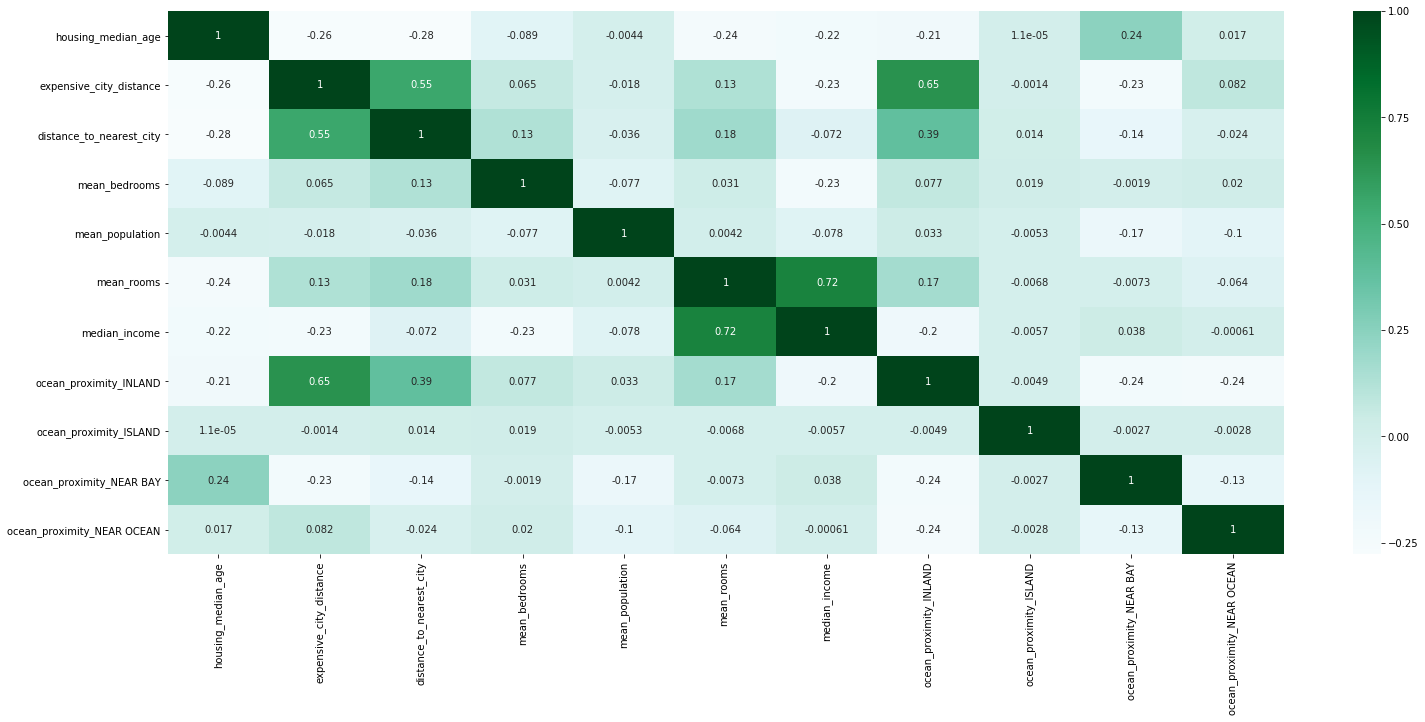

In [103]:
plt.rcParams["figure.figsize"] = "25,10"
sns.heatmap(pred_new.corr(), cmap ='BuGn', annot=True)

## Stacking Regressor

In [104]:
from mlxtend.regressor import StackingRegressor

In [111]:
stregr = StackingRegressor(regressors=[lr, svr_rbf, gboost_cv], meta_regressor=xgb_cv)

In [112]:
stregr.fit(pred_train, res_train)
res_pred = stregr.predict(pred_test)

In [114]:
print(f'Variance score for Stacking Regressor Algorithm is: {r2_score(res_test, res_pred)}')
res_test_inv = inv_boxcox(res_test, maxlog)
res_pred_inv = inv_boxcox(res_pred, maxlog)
print(f'MSE : {mean_squared_error(res_test_inv,res_pred_inv)}')
rough_errors = np.round(np.sqrt(mean_squared_error(res_test_inv,res_pred_inv)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')

Variance score for Stacking Regressor Algorithm is: 0.8001477016489278
MSE : 2154178789.2463465
Model makes rough miscalculations of about $46413.13


In [115]:
stregr = StackingRegressor(regressors=[lr, svr_rbf, gboost_cv, xgb_cv], meta_regressor=mlpModel)

In [ ]:
stregr.fit(pred_train, res_train)
res_pred = stregr.predict(pred_test)

In [ ]:
print(f'Variance score for Stacking Regressor Algorithm is: {r2_score(res_test, res_pred)}')
res_test_inv = inv_boxcox(res_test, maxlog)
res_pred_inv = inv_boxcox(res_pred, maxlog)
print(f'MSE : {mean_squared_error(res_test_inv,res_pred_inv)}')
rough_errors = np.round(np.sqrt(mean_squared_error(res_test_inv,res_pred_inv)),2)
print(f'Model makes rough miscalculations of about ${rough_errors}')